# ECE 4194 Final Project. Spring 2019. The Ohio State University
## Authors: Michael Wharton.124, Alex Whitman.97, Benji Justice.251

This notebook is to train a resnet model to classify the actions specified in the dataset linked below.

Dataset: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions



### Define packages to autoreload

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport models.resnet
%aimport utils.data_helpers

### Import necessary modules

In [3]:
# torch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# import model
from models.resnet import resnet18

# data functions
from utils.data_helpers import load_data
from utils.data_helpers import har_dataset

# classics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

### Define model hyper parameters

In [4]:
# what percentage of data should be used for training 
split = 0.7

num_epoch = 2500
lr = 0.5e-7
batch_size = 10
num_workers = 1

### Create Model

### Handle GPU

In [5]:
use_gpu=True
if torch.cuda.is_available() and use_gpu:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor
    
    device = torch.device('cuda:1')
    
else:
    dtype = torch.FloatTensor
    ltype = torch.LongTensor
    device = torch.device('cpu')
    
print('device {} dtype {}'.format(device, dtype))

device cuda:1 dtype <class 'torch.cuda.FloatTensor'>


### Handle loss function and optimizer

### Track stats

### Load data

In [6]:
# ...
train_data, train_labels, test_data, test_labels = load_data()


In [7]:
# convert to torch Tensor objects
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)

test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

In [8]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

torch.Size([873, 2048, 6])
torch.Size([341, 2048, 6])
torch.Size([873])
torch.Size([341])


In [9]:
best_acc_list = []

drop_prob_list = [0.05, 0.1, 0.15] #, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.0]
num_tests = len(drop_prob_list)

results = np.zeros(shape=(num_tests, num_epoch, 2, 2))

### Train !

In [10]:
for test_num, drop_prob in enumerate(drop_prob_list):
    print('\ndrop prob {}'.format(drop_prob))
    model = resnet18(drop_prob=drop_prob)
    model = model.to(device)
    
    crit = torch.nn.CrossEntropyLoss()
    opt  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

    stats = np.zeros(shape=(num_epoch, 2, 2))

    # indices
    train = 0
    test  = 1
    acc   = 0
    loss  = 1


    train_ds = har_dataset(train_data, train_labels)
    train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers,shuffle=True)
    train_batches = train_dl.__len__()

    test_ds = har_dataset(test_data, test_labels)
    test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)
    test_batches = test_dl.__len__()

    best_acc = 0
    tstart = time.time()
    for epoch in range(num_epoch):

        # switch to train mode
        model.train()

        # track accuracy
        total = 0
        correct = 0

        # track loss
        tr_loss = []
        for batch, data in enumerate(train_dl):
            print('Training Iteration: {0:4d} of {1:4d}'.format(batch+1, train_batches), end='\r')

            # extract signal and labels
            signals, labels = data

            ## Normalize?

            # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
            signals = signals.transpose(1,2)

            # move data to device
            signals = signals.to(device)
            labels = labels.type(ltype).to(device)

            # process signals
            out = model(signals)

            # hard decision for classification
            _, pred = torch.max(out.data, 1)

    #         print(pred)
    #         print(labels)
    #         print()

            # compute accuracy
            total   += labels.size(0)
            correct += (pred == labels).sum().item()

            # compute loss
            b_loss = crit(out, labels)
            opt.zero_grad()
            b_loss.backward()
            opt.step()

            tr_loss.append(b_loss.item())

        # epoch training stats
        tr_accuracy = 100. * correct / total
        tr_loss = np.mean(tr_loss)

        # evaluate model
        model.eval()

        ts_loss = []
        total   = 0
        correct = 0
        with torch.no_grad():
            for batch, data in enumerate(test_dl):
                print('Testing  Iteration:: {0:4d} or {1:4d}'.format(batch+1, test_batches), end='\r')

                # extract signals and labels
                signals, labels = data

                # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
                signals = signals.transpose(1,2)

                # move data to device
                signals = signals.to(device)
                labels = labels.type(ltype).to(device)

                # process signals
                out = model(signals)

                # hard decision for classification
                _, pred = torch.max(out.data, 1)

                # compute accuracy
                total   += labels.size(0)
                correct += (pred == labels).sum().item()

                # compute loss
                b_loss = crit(out, labels)

                ts_loss.append(b_loss.item())
    
        # epoch testing stats
        ts_accuracy = 100. * correct / total
        ts_loss = np.mean(ts_loss)

        string=''
        if ts_accuracy > best_acc:
            best_acc = ts_accuracy
            string = 'save!'
            
        # save stats to plot later
        stats[epoch, train, loss ] = tr_loss
        stats[epoch, train, acc  ] = tr_accuracy
        stats[epoch, test,  loss ] = ts_loss
        stats[epoch, test,  acc  ] = ts_accuracy

        t1 = time.time() - tstart
        print('Epoch: {0:4d} Tr loss: {1:.6f} Ts loss: {2:.3f} Tr Accuracy: {3:3.2f}% Ts Accuracy: {4:3.2f}% Time: {5:4.2f}s p={6:0.2f} {7:s}'.format(
                epoch+1,      tr_loss,         ts_loss,         tr_accuracy,           ts_accuracy, t1, drop_prob, string))
    
    # save results of each model to plot
    results[test_num,:,:,:] = stats
    best_acc_list.append(best_acc)
    
np.savez('dropout_test',res=results)


drop prob 0.05
Epoch:    1 Tr loss: 2.754957 Ts loss: 2.549 Tr Accuracy: 9.62% Ts Accuracy: 9.97% Time: 10.46s p=0.05 save!
Epoch:    2 Tr loss: 2.761663 Ts loss: 2.550 Tr Accuracy: 9.74% Ts Accuracy: 13.20% Time: 14.77s p=0.05 save!
Epoch:    3 Tr loss: 2.694845 Ts loss: 2.521 Tr Accuracy: 11.68% Ts Accuracy: 13.49% Time: 18.90s p=0.05 save!
Epoch:    4 Tr loss: 2.655672 Ts loss: 2.530 Tr Accuracy: 12.49% Ts Accuracy: 11.14% Time: 22.83s p=0.05 
Epoch:    5 Tr loss: 2.697739 Ts loss: 2.496 Tr Accuracy: 10.31% Ts Accuracy: 12.32% Time: 26.64s p=0.05 
Epoch:    6 Tr loss: 2.636200 Ts loss: 2.491 Tr Accuracy: 12.94% Ts Accuracy: 13.49% Time: 30.45s p=0.05 
Epoch:    7 Tr loss: 2.620789 Ts loss: 2.463 Tr Accuracy: 10.88% Ts Accuracy: 15.84% Time: 34.45s p=0.05 save!
Epoch:    8 Tr loss: 2.596213 Ts loss: 2.444 Tr Accuracy: 13.86% Ts Accuracy: 14.96% Time: 38.39s p=0.05 
Epoch:    9 Tr loss: 2.590338 Ts loss: 2.430 Tr Accuracy: 11.23% Ts Accuracy: 15.54% Time: 42.21s p=0.05 
Epoch:   10 T

Epoch:   77 Tr loss: 1.922399 Ts loss: 1.899 Tr Accuracy: 30.36% Ts Accuracy: 39.88% Time: 318.08s p=0.05 save!
Epoch:   78 Tr loss: 1.921611 Ts loss: 1.874 Tr Accuracy: 31.84% Ts Accuracy: 39.00% Time: 321.67s p=0.05 
Epoch:   79 Tr loss: 1.882183 Ts loss: 1.883 Tr Accuracy: 32.65% Ts Accuracy: 39.00% Time: 325.23s p=0.05 
Epoch:   80 Tr loss: 1.936453 Ts loss: 1.917 Tr Accuracy: 29.32% Ts Accuracy: 35.78% Time: 328.69s p=0.05 
Epoch:   81 Tr loss: 1.889595 Ts loss: 1.865 Tr Accuracy: 32.76% Ts Accuracy: 37.54% Time: 332.28s p=0.05 
Epoch:   82 Tr loss: 1.895025 Ts loss: 1.833 Tr Accuracy: 30.70% Ts Accuracy: 39.59% Time: 336.07s p=0.05 
Epoch:   83 Tr loss: 1.913195 Ts loss: 1.867 Tr Accuracy: 30.81% Ts Accuracy: 39.59% Time: 340.23s p=0.05 
Epoch:   84 Tr loss: 1.878979 Ts loss: 1.864 Tr Accuracy: 30.93% Ts Accuracy: 41.35% Time: 343.94s p=0.05 save!
Epoch:   85 Tr loss: 1.837082 Ts loss: 1.847 Tr Accuracy: 35.05% Ts Accuracy: 39.59% Time: 347.58s p=0.05 
Epoch:   86 Tr loss: 1.8700

Epoch:  153 Tr loss: 1.597746 Ts loss: 1.584 Tr Accuracy: 46.74% Ts Accuracy: 53.08% Time: 603.71s p=0.05 
Epoch:  154 Tr loss: 1.599653 Ts loss: 1.609 Tr Accuracy: 44.67% Ts Accuracy: 53.67% Time: 607.46s p=0.05 
Epoch:  155 Tr loss: 1.571204 Ts loss: 1.636 Tr Accuracy: 45.82% Ts Accuracy: 52.49% Time: 610.92s p=0.05 
Epoch:  156 Tr loss: 1.572841 Ts loss: 1.581 Tr Accuracy: 46.39% Ts Accuracy: 55.72% Time: 614.62s p=0.05 save!
Epoch:  157 Tr loss: 1.566956 Ts loss: 1.616 Tr Accuracy: 47.54% Ts Accuracy: 55.72% Time: 617.99s p=0.05 
Epoch:  158 Tr loss: 1.590834 Ts loss: 1.583 Tr Accuracy: 45.13% Ts Accuracy: 52.20% Time: 621.88s p=0.05 
Epoch:  159 Tr loss: 1.582373 Ts loss: 1.583 Tr Accuracy: 45.48% Ts Accuracy: 53.67% Time: 625.84s p=0.05 
Epoch:  160 Tr loss: 1.547135 Ts loss: 1.570 Tr Accuracy: 48.11% Ts Accuracy: 54.84% Time: 629.65s p=0.05 
Epoch:  161 Tr loss: 1.557755 Ts loss: 1.572 Tr Accuracy: 49.26% Ts Accuracy: 53.08% Time: 633.13s p=0.05 
Epoch:  162 Tr loss: 1.555994 Ts

Epoch:  229 Tr loss: 1.341617 Ts loss: 1.431 Tr Accuracy: 60.37% Ts Accuracy: 60.41% Time: 891.61s p=0.05 
Epoch:  230 Tr loss: 1.358006 Ts loss: 1.393 Tr Accuracy: 55.78% Ts Accuracy: 60.41% Time: 894.97s p=0.05 
Epoch:  231 Tr loss: 1.369433 Ts loss: 1.356 Tr Accuracy: 55.78% Ts Accuracy: 60.41% Time: 898.56s p=0.05 
Epoch:  232 Tr loss: 1.344534 Ts loss: 1.421 Tr Accuracy: 57.73% Ts Accuracy: 59.53% Time: 902.62s p=0.05 
Epoch:  233 Tr loss: 1.344342 Ts loss: 1.377 Tr Accuracy: 59.11% Ts Accuracy: 59.82% Time: 906.30s p=0.05 
Epoch:  234 Tr loss: 1.344914 Ts loss: 1.388 Tr Accuracy: 57.04% Ts Accuracy: 60.41% Time: 910.02s p=0.05 
Epoch:  235 Tr loss: 1.354786 Ts loss: 1.378 Tr Accuracy: 55.67% Ts Accuracy: 59.82% Time: 913.57s p=0.05 
Epoch:  236 Tr loss: 1.359210 Ts loss: 1.396 Tr Accuracy: 56.59% Ts Accuracy: 58.06% Time: 917.16s p=0.05 
Epoch:  237 Tr loss: 1.335093 Ts loss: 1.374 Tr Accuracy: 58.30% Ts Accuracy: 62.46% Time: 920.76s p=0.05 save!
Epoch:  238 Tr loss: 1.339971 Ts

Epoch:  305 Tr loss: 1.210673 Ts loss: 1.240 Tr Accuracy: 61.28% Ts Accuracy: 62.46% Time: 1171.24s p=0.05 
Epoch:  306 Tr loss: 1.202110 Ts loss: 1.255 Tr Accuracy: 62.43% Ts Accuracy: 61.88% Time: 1175.03s p=0.05 
Epoch:  307 Tr loss: 1.210543 Ts loss: 1.230 Tr Accuracy: 62.08% Ts Accuracy: 63.64% Time: 1179.13s p=0.05 
Epoch:  308 Tr loss: 1.177992 Ts loss: 1.242 Tr Accuracy: 63.34% Ts Accuracy: 63.64% Time: 1182.50s p=0.05 
Epoch:  309 Tr loss: 1.179157 Ts loss: 1.234 Tr Accuracy: 63.69% Ts Accuracy: 64.52% Time: 1185.81s p=0.05 
Epoch:  310 Tr loss: 1.188523 Ts loss: 1.211 Tr Accuracy: 61.63% Ts Accuracy: 65.69% Time: 1189.04s p=0.05 
Epoch:  311 Tr loss: 1.192068 Ts loss: 1.254 Tr Accuracy: 62.89% Ts Accuracy: 62.76% Time: 1192.96s p=0.05 
Epoch:  312 Tr loss: 1.181288 Ts loss: 1.200 Tr Accuracy: 63.12% Ts Accuracy: 64.81% Time: 1196.73s p=0.05 
Epoch:  313 Tr loss: 1.181009 Ts loss: 1.225 Tr Accuracy: 66.55% Ts Accuracy: 63.93% Time: 1200.30s p=0.05 
Epoch:  314 Tr loss: 1.17641

Epoch:  381 Tr loss: 1.060030 Ts loss: 1.107 Tr Accuracy: 69.30% Ts Accuracy: 66.57% Time: 1459.30s p=0.05 
Epoch:  382 Tr loss: 1.068733 Ts loss: 1.159 Tr Accuracy: 68.27% Ts Accuracy: 64.52% Time: 1462.92s p=0.05 
Epoch:  383 Tr loss: 1.059174 Ts loss: 1.150 Tr Accuracy: 66.09% Ts Accuracy: 65.69% Time: 1466.85s p=0.05 
Epoch:  384 Tr loss: 1.059399 Ts loss: 1.102 Tr Accuracy: 68.61% Ts Accuracy: 67.16% Time: 1471.04s p=0.05 
Epoch:  385 Tr loss: 1.042722 Ts loss: 1.110 Tr Accuracy: 69.30% Ts Accuracy: 67.74% Time: 1474.92s p=0.05 
Epoch:  386 Tr loss: 1.041332 Ts loss: 1.084 Tr Accuracy: 71.25% Ts Accuracy: 69.21% Time: 1478.85s p=0.05 
Epoch:  387 Tr loss: 1.069638 Ts loss: 1.079 Tr Accuracy: 67.12% Ts Accuracy: 68.91% Time: 1482.34s p=0.05 
Epoch:  388 Tr loss: 1.074298 Ts loss: 1.089 Tr Accuracy: 66.78% Ts Accuracy: 67.16% Time: 1486.12s p=0.05 
Epoch:  389 Tr loss: 1.059789 Ts loss: 1.151 Tr Accuracy: 68.50% Ts Accuracy: 64.81% Time: 1490.04s p=0.05 
Epoch:  390 Tr loss: 1.07749

Epoch:  457 Tr loss: 0.968918 Ts loss: 1.026 Tr Accuracy: 69.99% Ts Accuracy: 67.16% Time: 1748.71s p=0.05 
Epoch:  458 Tr loss: 0.958690 Ts loss: 1.029 Tr Accuracy: 70.90% Ts Accuracy: 70.67% Time: 1752.93s p=0.05 
Epoch:  459 Tr loss: 0.955779 Ts loss: 0.985 Tr Accuracy: 73.20% Ts Accuracy: 70.67% Time: 1756.67s p=0.05 
Epoch:  460 Tr loss: 0.953514 Ts loss: 0.992 Tr Accuracy: 70.90% Ts Accuracy: 69.50% Time: 1760.53s p=0.05 
Epoch:  461 Tr loss: 0.958235 Ts loss: 1.031 Tr Accuracy: 70.33% Ts Accuracy: 66.57% Time: 1764.28s p=0.05 
Epoch:  462 Tr loss: 0.964545 Ts loss: 1.046 Tr Accuracy: 70.68% Ts Accuracy: 69.50% Time: 1768.24s p=0.05 
Epoch:  463 Tr loss: 0.969418 Ts loss: 0.988 Tr Accuracy: 69.30% Ts Accuracy: 69.50% Time: 1771.98s p=0.05 
Epoch:  464 Tr loss: 0.966688 Ts loss: 0.958 Tr Accuracy: 70.33% Ts Accuracy: 70.38% Time: 1775.86s p=0.05 
Epoch:  465 Tr loss: 0.957835 Ts loss: 1.059 Tr Accuracy: 69.19% Ts Accuracy: 67.16% Time: 1779.68s p=0.05 
Epoch:  466 Tr loss: 0.95928

Epoch:  533 Tr loss: 0.894619 Ts loss: 0.915 Tr Accuracy: 72.74% Ts Accuracy: 72.73% Time: 2038.44s p=0.05 
Epoch:  534 Tr loss: 0.887904 Ts loss: 0.921 Tr Accuracy: 72.85% Ts Accuracy: 71.55% Time: 2041.85s p=0.05 
Epoch:  535 Tr loss: 0.925429 Ts loss: 0.948 Tr Accuracy: 70.79% Ts Accuracy: 70.67% Time: 2045.65s p=0.05 
Epoch:  536 Tr loss: 0.912520 Ts loss: 0.909 Tr Accuracy: 71.02% Ts Accuracy: 73.31% Time: 2049.74s p=0.05 save!
Epoch:  537 Tr loss: 0.891341 Ts loss: 0.910 Tr Accuracy: 71.94% Ts Accuracy: 74.78% Time: 2053.44s p=0.05 save!
Epoch:  538 Tr loss: 0.886715 Ts loss: 0.971 Tr Accuracy: 72.74% Ts Accuracy: 70.38% Time: 2057.37s p=0.05 
Epoch:  539 Tr loss: 0.875091 Ts loss: 0.898 Tr Accuracy: 74.23% Ts Accuracy: 74.19% Time: 2061.14s p=0.05 
Epoch:  540 Tr loss: 0.892963 Ts loss: 0.906 Tr Accuracy: 72.74% Ts Accuracy: 74.78% Time: 2064.73s p=0.05 
Epoch:  541 Tr loss: 0.884896 Ts loss: 0.930 Tr Accuracy: 73.20% Ts Accuracy: 71.55% Time: 2068.16s p=0.05 
Epoch:  542 Tr los

Epoch:  609 Tr loss: 0.821830 Ts loss: 0.845 Tr Accuracy: 75.26% Ts Accuracy: 75.95% Time: 2329.56s p=0.05 save!
Epoch:  610 Tr loss: 0.847879 Ts loss: 0.835 Tr Accuracy: 73.65% Ts Accuracy: 74.19% Time: 2333.69s p=0.05 
Epoch:  611 Tr loss: 0.816568 Ts loss: 0.863 Tr Accuracy: 75.14% Ts Accuracy: 73.31% Time: 2337.32s p=0.05 
Epoch:  612 Tr loss: 0.824225 Ts loss: 0.860 Tr Accuracy: 74.91% Ts Accuracy: 74.78% Time: 2340.85s p=0.05 
Epoch:  613 Tr loss: 0.823399 Ts loss: 0.879 Tr Accuracy: 74.11% Ts Accuracy: 73.61% Time: 2344.84s p=0.05 
Epoch:  614 Tr loss: 0.821950 Ts loss: 0.892 Tr Accuracy: 74.91% Ts Accuracy: 73.90% Time: 2348.87s p=0.05 
Epoch:  615 Tr loss: 0.805301 Ts loss: 0.874 Tr Accuracy: 78.12% Ts Accuracy: 74.19% Time: 2352.65s p=0.05 
Epoch:  616 Tr loss: 0.810586 Ts loss: 0.821 Tr Accuracy: 76.63% Ts Accuracy: 75.37% Time: 2356.64s p=0.05 
Epoch:  617 Tr loss: 0.800723 Ts loss: 0.847 Tr Accuracy: 76.63% Ts Accuracy: 75.07% Time: 2360.28s p=0.05 
Epoch:  618 Tr loss: 0.

Epoch:  685 Tr loss: 0.779052 Ts loss: 0.809 Tr Accuracy: 74.57% Ts Accuracy: 75.07% Time: 2632.47s p=0.05 
Epoch:  686 Tr loss: 0.777776 Ts loss: 0.832 Tr Accuracy: 76.75% Ts Accuracy: 74.78% Time: 2636.25s p=0.05 
Epoch:  687 Tr loss: 0.756701 Ts loss: 0.786 Tr Accuracy: 77.55% Ts Accuracy: 76.25% Time: 2639.84s p=0.05 
Epoch:  688 Tr loss: 0.775293 Ts loss: 0.809 Tr Accuracy: 75.95% Ts Accuracy: 75.07% Time: 2643.93s p=0.05 
Epoch:  689 Tr loss: 0.776629 Ts loss: 0.810 Tr Accuracy: 76.63% Ts Accuracy: 75.07% Time: 2647.59s p=0.05 
Epoch:  690 Tr loss: 0.769036 Ts loss: 0.844 Tr Accuracy: 75.95% Ts Accuracy: 73.31% Time: 2651.43s p=0.05 
Epoch:  691 Tr loss: 0.775848 Ts loss: 0.846 Tr Accuracy: 76.17% Ts Accuracy: 74.19% Time: 2655.21s p=0.05 
Epoch:  692 Tr loss: 0.783817 Ts loss: 0.805 Tr Accuracy: 75.03% Ts Accuracy: 76.83% Time: 2659.02s p=0.05 
Epoch:  693 Tr loss: 0.769785 Ts loss: 0.779 Tr Accuracy: 76.86% Ts Accuracy: 76.25% Time: 2663.11s p=0.05 
Epoch:  694 Tr loss: 0.76598

Epoch:  761 Tr loss: 0.721795 Ts loss: 0.744 Tr Accuracy: 78.69% Ts Accuracy: 77.42% Time: 2924.35s p=0.05 
Epoch:  762 Tr loss: 0.760199 Ts loss: 0.743 Tr Accuracy: 77.21% Ts Accuracy: 76.54% Time: 2928.03s p=0.05 
Epoch:  763 Tr loss: 0.709964 Ts loss: 0.796 Tr Accuracy: 77.55% Ts Accuracy: 76.54% Time: 2932.15s p=0.05 
Epoch:  764 Tr loss: 0.690310 Ts loss: 0.762 Tr Accuracy: 79.84% Ts Accuracy: 78.01% Time: 2935.97s p=0.05 
Epoch:  765 Tr loss: 0.735226 Ts loss: 0.754 Tr Accuracy: 76.06% Ts Accuracy: 78.01% Time: 2939.61s p=0.05 
Epoch:  766 Tr loss: 0.716833 Ts loss: 0.760 Tr Accuracy: 79.38% Ts Accuracy: 77.13% Time: 2943.52s p=0.05 
Epoch:  767 Tr loss: 0.713837 Ts loss: 0.783 Tr Accuracy: 78.58% Ts Accuracy: 78.30% Time: 2947.09s p=0.05 
Epoch:  768 Tr loss: 0.720089 Ts loss: 0.758 Tr Accuracy: 77.78% Ts Accuracy: 78.59% Time: 2951.17s p=0.05 
Epoch:  769 Tr loss: 0.720521 Ts loss: 0.752 Tr Accuracy: 77.89% Ts Accuracy: 76.83% Time: 2954.93s p=0.05 
Epoch:  770 Tr loss: 0.71375

Epoch:  837 Tr loss: 0.678385 Ts loss: 0.701 Tr Accuracy: 79.73% Ts Accuracy: 79.47% Time: 3213.87s p=0.05 
Epoch:  838 Tr loss: 0.672545 Ts loss: 0.700 Tr Accuracy: 80.07% Ts Accuracy: 78.59% Time: 3217.64s p=0.05 
Epoch:  839 Tr loss: 0.681355 Ts loss: 0.730 Tr Accuracy: 78.24% Ts Accuracy: 79.18% Time: 3221.58s p=0.05 
Epoch:  840 Tr loss: 0.671124 Ts loss: 0.720 Tr Accuracy: 80.30% Ts Accuracy: 78.89% Time: 3224.93s p=0.05 
Epoch:  841 Tr loss: 0.684340 Ts loss: 0.724 Tr Accuracy: 79.27% Ts Accuracy: 78.89% Time: 3228.81s p=0.05 
Epoch:  842 Tr loss: 0.677754 Ts loss: 0.730 Tr Accuracy: 77.43% Ts Accuracy: 78.59% Time: 3232.68s p=0.05 
Epoch:  843 Tr loss: 0.681480 Ts loss: 0.711 Tr Accuracy: 79.50% Ts Accuracy: 78.59% Time: 3236.74s p=0.05 
Epoch:  844 Tr loss: 0.686855 Ts loss: 0.720 Tr Accuracy: 79.73% Ts Accuracy: 80.35% Time: 3240.24s p=0.05 
Epoch:  845 Tr loss: 0.666310 Ts loss: 0.699 Tr Accuracy: 80.53% Ts Accuracy: 79.18% Time: 3244.42s p=0.05 
Epoch:  846 Tr loss: 0.69199

Epoch:  913 Tr loss: 0.637020 Ts loss: 0.671 Tr Accuracy: 79.50% Ts Accuracy: 81.82% Time: 3505.17s p=0.05 save!
Epoch:  914 Tr loss: 0.639297 Ts loss: 0.704 Tr Accuracy: 79.73% Ts Accuracy: 80.35% Time: 3508.88s p=0.05 
Epoch:  915 Tr loss: 0.635669 Ts loss: 0.690 Tr Accuracy: 80.99% Ts Accuracy: 82.40% Time: 3512.62s p=0.05 save!
Epoch:  916 Tr loss: 0.633817 Ts loss: 0.695 Tr Accuracy: 79.73% Ts Accuracy: 79.18% Time: 3516.90s p=0.05 
Epoch:  917 Tr loss: 0.645621 Ts loss: 0.676 Tr Accuracy: 79.15% Ts Accuracy: 81.23% Time: 3521.08s p=0.05 
Epoch:  918 Tr loss: 0.646591 Ts loss: 0.673 Tr Accuracy: 79.73% Ts Accuracy: 80.35% Time: 3524.99s p=0.05 
Epoch:  919 Tr loss: 0.649412 Ts loss: 0.674 Tr Accuracy: 79.27% Ts Accuracy: 80.35% Time: 3528.42s p=0.05 
Epoch:  920 Tr loss: 0.638267 Ts loss: 0.685 Tr Accuracy: 80.64% Ts Accuracy: 82.11% Time: 3532.29s p=0.05 
Epoch:  921 Tr loss: 0.630353 Ts loss: 0.683 Tr Accuracy: 80.76% Ts Accuracy: 80.06% Time: 3535.59s p=0.05 
Epoch:  922 Tr los

Epoch:  989 Tr loss: 0.613620 Ts loss: 0.646 Tr Accuracy: 80.18% Ts Accuracy: 81.23% Time: 3792.75s p=0.05 
Epoch:  990 Tr loss: 0.609579 Ts loss: 0.651 Tr Accuracy: 80.18% Ts Accuracy: 81.52% Time: 3796.64s p=0.05 
Epoch:  991 Tr loss: 0.597418 Ts loss: 0.643 Tr Accuracy: 81.67% Ts Accuracy: 80.94% Time: 3800.32s p=0.05 
Epoch:  992 Tr loss: 0.622450 Ts loss: 0.632 Tr Accuracy: 80.41% Ts Accuracy: 80.65% Time: 3804.16s p=0.05 
Epoch:  993 Tr loss: 0.614199 Ts loss: 0.658 Tr Accuracy: 80.87% Ts Accuracy: 82.40% Time: 3808.32s p=0.05 
Epoch:  994 Tr loss: 0.638746 Ts loss: 0.642 Tr Accuracy: 80.07% Ts Accuracy: 82.11% Time: 3812.17s p=0.05 
Epoch:  995 Tr loss: 0.619262 Ts loss: 0.646 Tr Accuracy: 80.76% Ts Accuracy: 81.52% Time: 3815.73s p=0.05 
Epoch:  996 Tr loss: 0.595731 Ts loss: 0.675 Tr Accuracy: 82.82% Ts Accuracy: 80.35% Time: 3819.87s p=0.05 
Epoch:  997 Tr loss: 0.629383 Ts loss: 0.647 Tr Accuracy: 80.18% Ts Accuracy: 80.06% Time: 3823.61s p=0.05 
Epoch:  998 Tr loss: 0.62146

Epoch: 1065 Tr loss: 0.593829 Ts loss: 0.637 Tr Accuracy: 80.64% Ts Accuracy: 81.52% Time: 4083.41s p=0.05 
Epoch: 1066 Tr loss: 0.568400 Ts loss: 0.630 Tr Accuracy: 83.28% Ts Accuracy: 82.70% Time: 4087.09s p=0.05 
Epoch: 1067 Tr loss: 0.580285 Ts loss: 0.612 Tr Accuracy: 82.02% Ts Accuracy: 82.11% Time: 4090.81s p=0.05 
Epoch: 1068 Tr loss: 0.570189 Ts loss: 0.601 Tr Accuracy: 82.13% Ts Accuracy: 82.99% Time: 4094.29s p=0.05 
Epoch: 1069 Tr loss: 0.599492 Ts loss: 0.637 Tr Accuracy: 79.95% Ts Accuracy: 81.52% Time: 4098.41s p=0.05 
Epoch: 1070 Tr loss: 0.568238 Ts loss: 0.639 Tr Accuracy: 83.51% Ts Accuracy: 81.82% Time: 4102.52s p=0.05 
Epoch: 1071 Tr loss: 0.573804 Ts loss: 0.610 Tr Accuracy: 80.99% Ts Accuracy: 82.11% Time: 4106.30s p=0.05 
Epoch: 1072 Tr loss: 0.577283 Ts loss: 0.607 Tr Accuracy: 81.79% Ts Accuracy: 82.70% Time: 4109.49s p=0.05 
Epoch: 1073 Tr loss: 0.585229 Ts loss: 0.599 Tr Accuracy: 83.28% Ts Accuracy: 82.40% Time: 4113.24s p=0.05 
Epoch: 1074 Tr loss: 0.59110

Epoch: 1141 Tr loss: 0.588556 Ts loss: 0.602 Tr Accuracy: 81.79% Ts Accuracy: 83.28% Time: 4372.93s p=0.05 
Epoch: 1142 Tr loss: 0.581202 Ts loss: 0.630 Tr Accuracy: 82.13% Ts Accuracy: 81.52% Time: 4376.92s p=0.05 
Epoch: 1143 Tr loss: 0.574887 Ts loss: 0.577 Tr Accuracy: 81.56% Ts Accuracy: 83.87% Time: 4380.64s p=0.05 
Epoch: 1144 Tr loss: 0.554693 Ts loss: 0.582 Tr Accuracy: 81.90% Ts Accuracy: 83.28% Time: 4384.51s p=0.05 
Epoch: 1145 Tr loss: 0.552314 Ts loss: 0.603 Tr Accuracy: 82.13% Ts Accuracy: 82.99% Time: 4388.69s p=0.05 
Epoch: 1146 Tr loss: 0.549602 Ts loss: 0.588 Tr Accuracy: 82.13% Ts Accuracy: 84.16% Time: 4392.97s p=0.05 
Epoch: 1147 Tr loss: 0.556977 Ts loss: 0.577 Tr Accuracy: 82.93% Ts Accuracy: 84.16% Time: 4397.04s p=0.05 
Epoch: 1148 Tr loss: 0.562458 Ts loss: 0.592 Tr Accuracy: 82.13% Ts Accuracy: 83.58% Time: 4400.85s p=0.05 
Epoch: 1149 Tr loss: 0.550636 Ts loss: 0.605 Tr Accuracy: 82.25% Ts Accuracy: 81.82% Time: 4404.70s p=0.05 
Epoch: 1150 Tr loss: 0.55298

Epoch: 1217 Tr loss: 0.526528 Ts loss: 0.565 Tr Accuracy: 83.51% Ts Accuracy: 84.16% Time: 4668.59s p=0.05 
Epoch: 1218 Tr loss: 0.524611 Ts loss: 0.571 Tr Accuracy: 83.85% Ts Accuracy: 82.70% Time: 4672.69s p=0.05 
Epoch: 1219 Tr loss: 0.537373 Ts loss: 0.579 Tr Accuracy: 84.08% Ts Accuracy: 84.46% Time: 4676.54s p=0.05 
Epoch: 1220 Tr loss: 0.530134 Ts loss: 0.582 Tr Accuracy: 81.44% Ts Accuracy: 83.87% Time: 4680.43s p=0.05 
Epoch: 1221 Tr loss: 0.525475 Ts loss: 0.554 Tr Accuracy: 84.08% Ts Accuracy: 84.46% Time: 4684.54s p=0.05 
Epoch: 1222 Tr loss: 0.519628 Ts loss: 0.578 Tr Accuracy: 83.85% Ts Accuracy: 84.16% Time: 4687.90s p=0.05 
Epoch: 1223 Tr loss: 0.534745 Ts loss: 0.557 Tr Accuracy: 82.59% Ts Accuracy: 83.28% Time: 4691.62s p=0.05 
Epoch: 1224 Tr loss: 0.504622 Ts loss: 0.599 Tr Accuracy: 84.42% Ts Accuracy: 81.82% Time: 4695.14s p=0.05 
Epoch: 1225 Tr loss: 0.537047 Ts loss: 0.545 Tr Accuracy: 83.96% Ts Accuracy: 84.75% Time: 4699.46s p=0.05 
Epoch: 1226 Tr loss: 0.56884

Epoch: 1293 Tr loss: 0.502576 Ts loss: 0.553 Tr Accuracy: 84.54% Ts Accuracy: 83.87% Time: 4960.23s p=0.05 
Epoch: 1294 Tr loss: 0.527711 Ts loss: 0.547 Tr Accuracy: 82.25% Ts Accuracy: 82.99% Time: 4964.17s p=0.05 
Epoch: 1295 Tr loss: 0.503139 Ts loss: 0.538 Tr Accuracy: 83.62% Ts Accuracy: 85.34% Time: 4968.23s p=0.05 
Epoch: 1296 Tr loss: 0.509654 Ts loss: 0.563 Tr Accuracy: 84.08% Ts Accuracy: 82.40% Time: 4972.36s p=0.05 
Epoch: 1297 Tr loss: 0.524728 Ts loss: 0.560 Tr Accuracy: 82.93% Ts Accuracy: 85.04% Time: 4976.34s p=0.05 
Epoch: 1298 Tr loss: 0.511378 Ts loss: 0.552 Tr Accuracy: 84.88% Ts Accuracy: 85.34% Time: 4980.07s p=0.05 
Epoch: 1299 Tr loss: 0.538872 Ts loss: 0.537 Tr Accuracy: 82.82% Ts Accuracy: 85.63% Time: 4983.87s p=0.05 
Epoch: 1300 Tr loss: 0.499417 Ts loss: 0.549 Tr Accuracy: 83.05% Ts Accuracy: 84.46% Time: 4987.66s p=0.05 
Epoch: 1301 Tr loss: 0.498148 Ts loss: 0.560 Tr Accuracy: 83.62% Ts Accuracy: 83.58% Time: 4991.90s p=0.05 
Epoch: 1302 Tr loss: 0.51354

Epoch: 1369 Tr loss: 0.502654 Ts loss: 0.519 Tr Accuracy: 84.42% Ts Accuracy: 85.04% Time: 5259.82s p=0.05 
Epoch: 1370 Tr loss: 0.479026 Ts loss: 0.515 Tr Accuracy: 84.99% Ts Accuracy: 87.10% Time: 5263.89s p=0.05 save!
Epoch: 1371 Tr loss: 0.484156 Ts loss: 0.538 Tr Accuracy: 84.99% Ts Accuracy: 84.16% Time: 5268.17s p=0.05 
Epoch: 1372 Tr loss: 0.505850 Ts loss: 0.520 Tr Accuracy: 85.11% Ts Accuracy: 84.75% Time: 5272.10s p=0.05 
Epoch: 1373 Tr loss: 0.481092 Ts loss: 0.540 Tr Accuracy: 87.06% Ts Accuracy: 84.75% Time: 5275.93s p=0.05 
Epoch: 1374 Tr loss: 0.475157 Ts loss: 0.518 Tr Accuracy: 85.34% Ts Accuracy: 85.04% Time: 5279.62s p=0.05 
Epoch: 1375 Tr loss: 0.484705 Ts loss: 0.524 Tr Accuracy: 84.19% Ts Accuracy: 86.22% Time: 5283.69s p=0.05 
Epoch: 1376 Tr loss: 0.510831 Ts loss: 0.529 Tr Accuracy: 83.73% Ts Accuracy: 85.04% Time: 5287.47s p=0.05 
Epoch: 1377 Tr loss: 0.502028 Ts loss: 0.521 Tr Accuracy: 85.45% Ts Accuracy: 84.16% Time: 5290.95s p=0.05 
Epoch: 1378 Tr loss: 0.

Epoch: 1445 Tr loss: 0.473556 Ts loss: 0.504 Tr Accuracy: 84.77% Ts Accuracy: 85.63% Time: 5554.89s p=0.05 
Epoch: 1446 Tr loss: 0.482273 Ts loss: 0.515 Tr Accuracy: 85.34% Ts Accuracy: 85.92% Time: 5558.74s p=0.05 
Epoch: 1447 Tr loss: 0.488309 Ts loss: 0.509 Tr Accuracy: 84.99% Ts Accuracy: 85.63% Time: 5562.64s p=0.05 
Epoch: 1448 Tr loss: 0.479574 Ts loss: 0.515 Tr Accuracy: 83.96% Ts Accuracy: 86.51% Time: 5566.34s p=0.05 
Epoch: 1449 Tr loss: 0.462565 Ts loss: 0.503 Tr Accuracy: 85.80% Ts Accuracy: 84.46% Time: 5570.05s p=0.05 
Epoch: 1450 Tr loss: 0.459903 Ts loss: 0.531 Tr Accuracy: 86.37% Ts Accuracy: 84.46% Time: 5573.91s p=0.05 
Epoch: 1451 Tr loss: 0.478950 Ts loss: 0.520 Tr Accuracy: 83.96% Ts Accuracy: 85.63% Time: 5577.91s p=0.05 
Epoch: 1452 Tr loss: 0.468989 Ts loss: 0.484 Tr Accuracy: 84.77% Ts Accuracy: 86.22% Time: 5581.83s p=0.05 
Epoch: 1453 Tr loss: 0.472509 Ts loss: 0.495 Tr Accuracy: 83.96% Ts Accuracy: 86.22% Time: 5585.78s p=0.05 
Epoch: 1454 Tr loss: 0.47536

Epoch: 1521 Tr loss: 0.454222 Ts loss: 0.480 Tr Accuracy: 85.34% Ts Accuracy: 86.51% Time: 5848.49s p=0.05 
Epoch: 1522 Tr loss: 0.445320 Ts loss: 0.477 Tr Accuracy: 85.22% Ts Accuracy: 85.34% Time: 5852.32s p=0.05 
Epoch: 1523 Tr loss: 0.453429 Ts loss: 0.492 Tr Accuracy: 85.34% Ts Accuracy: 84.46% Time: 5855.96s p=0.05 
Epoch: 1524 Tr loss: 0.432452 Ts loss: 0.482 Tr Accuracy: 87.51% Ts Accuracy: 85.92% Time: 5859.65s p=0.05 
Epoch: 1525 Tr loss: 0.441580 Ts loss: 0.500 Tr Accuracy: 87.06% Ts Accuracy: 85.04% Time: 5863.60s p=0.05 
Epoch: 1526 Tr loss: 0.468476 Ts loss: 0.464 Tr Accuracy: 83.62% Ts Accuracy: 87.10% Time: 5867.43s p=0.05 
Epoch: 1527 Tr loss: 0.458464 Ts loss: 0.486 Tr Accuracy: 84.99% Ts Accuracy: 86.51% Time: 5871.33s p=0.05 
Epoch: 1528 Tr loss: 0.441874 Ts loss: 0.466 Tr Accuracy: 87.40% Ts Accuracy: 86.51% Time: 5874.66s p=0.05 
Epoch: 1529 Tr loss: 0.442992 Ts loss: 0.491 Tr Accuracy: 86.71% Ts Accuracy: 86.22% Time: 5878.16s p=0.05 
Epoch: 1530 Tr loss: 0.45511

Epoch: 1597 Tr loss: 0.430153 Ts loss: 0.479 Tr Accuracy: 86.25% Ts Accuracy: 86.22% Time: 6138.78s p=0.05 
Epoch: 1598 Tr loss: 0.441185 Ts loss: 0.478 Tr Accuracy: 85.34% Ts Accuracy: 85.92% Time: 6142.42s p=0.05 
Epoch: 1599 Tr loss: 0.427446 Ts loss: 0.465 Tr Accuracy: 86.14% Ts Accuracy: 86.22% Time: 6146.16s p=0.05 
Epoch: 1600 Tr loss: 0.426491 Ts loss: 0.469 Tr Accuracy: 86.14% Ts Accuracy: 87.10% Time: 6149.81s p=0.05 
Epoch: 1601 Tr loss: 0.432312 Ts loss: 0.457 Tr Accuracy: 87.29% Ts Accuracy: 86.51% Time: 6154.01s p=0.05 
Epoch: 1602 Tr loss: 0.447284 Ts loss: 0.470 Tr Accuracy: 85.45% Ts Accuracy: 87.39% Time: 6157.51s p=0.05 
Epoch: 1603 Tr loss: 0.436789 Ts loss: 0.484 Tr Accuracy: 86.03% Ts Accuracy: 85.63% Time: 6161.75s p=0.05 
Epoch: 1604 Tr loss: 0.431745 Ts loss: 0.485 Tr Accuracy: 86.48% Ts Accuracy: 86.22% Time: 6165.06s p=0.05 
Epoch: 1605 Tr loss: 0.419882 Ts loss: 0.470 Tr Accuracy: 88.09% Ts Accuracy: 87.10% Time: 6168.46s p=0.05 
Epoch: 1606 Tr loss: 0.45975

Epoch: 1673 Tr loss: 0.429402 Ts loss: 0.440 Tr Accuracy: 87.06% Ts Accuracy: 87.39% Time: 6431.55s p=0.05 
Epoch: 1674 Tr loss: 0.447995 Ts loss: 0.422 Tr Accuracy: 86.14% Ts Accuracy: 87.98% Time: 6435.10s p=0.05 
Epoch: 1675 Tr loss: 0.416678 Ts loss: 0.452 Tr Accuracy: 86.60% Ts Accuracy: 86.22% Time: 6439.25s p=0.05 
Epoch: 1676 Tr loss: 0.420478 Ts loss: 0.433 Tr Accuracy: 87.29% Ts Accuracy: 88.27% Time: 6443.31s p=0.05 
Epoch: 1677 Tr loss: 0.424784 Ts loss: 0.428 Tr Accuracy: 86.48% Ts Accuracy: 87.39% Time: 6447.00s p=0.05 
Epoch: 1678 Tr loss: 0.440744 Ts loss: 0.452 Tr Accuracy: 86.37% Ts Accuracy: 86.51% Time: 6450.92s p=0.05 
Epoch: 1679 Tr loss: 0.415379 Ts loss: 0.454 Tr Accuracy: 87.97% Ts Accuracy: 87.10% Time: 6454.54s p=0.05 
Epoch: 1680 Tr loss: 0.430487 Ts loss: 0.441 Tr Accuracy: 86.71% Ts Accuracy: 86.80% Time: 6458.57s p=0.05 
Epoch: 1681 Tr loss: 0.424607 Ts loss: 0.445 Tr Accuracy: 86.83% Ts Accuracy: 86.51% Time: 6462.43s p=0.05 
Epoch: 1682 Tr loss: 0.41963

Epoch: 1749 Tr loss: 0.407023 Ts loss: 0.444 Tr Accuracy: 86.94% Ts Accuracy: 86.22% Time: 6720.93s p=0.05 
Epoch: 1750 Tr loss: 0.390281 Ts loss: 0.433 Tr Accuracy: 87.29% Ts Accuracy: 87.10% Time: 6724.92s p=0.05 
Epoch: 1751 Tr loss: 0.420534 Ts loss: 0.454 Tr Accuracy: 87.63% Ts Accuracy: 86.80% Time: 6728.86s p=0.05 
Epoch: 1752 Tr loss: 0.399425 Ts loss: 0.440 Tr Accuracy: 87.97% Ts Accuracy: 87.39% Time: 6732.67s p=0.05 
Epoch: 1753 Tr loss: 0.406126 Ts loss: 0.434 Tr Accuracy: 87.40% Ts Accuracy: 87.98% Time: 6736.31s p=0.05 
Epoch: 1754 Tr loss: 0.404323 Ts loss: 0.442 Tr Accuracy: 87.97% Ts Accuracy: 87.98% Time: 6740.22s p=0.05 
Epoch: 1755 Tr loss: 0.409370 Ts loss: 0.431 Tr Accuracy: 86.14% Ts Accuracy: 87.39% Time: 6744.09s p=0.05 
Epoch: 1756 Tr loss: 0.412832 Ts loss: 0.430 Tr Accuracy: 86.94% Ts Accuracy: 88.86% Time: 6748.08s p=0.05 save!
Epoch: 1757 Tr loss: 0.412863 Ts loss: 0.434 Tr Accuracy: 87.51% Ts Accuracy: 87.10% Time: 6752.47s p=0.05 
Epoch: 1758 Tr loss: 0.

Epoch: 1825 Tr loss: 0.390785 Ts loss: 0.417 Tr Accuracy: 86.83% Ts Accuracy: 87.39% Time: 7011.79s p=0.05 
Epoch: 1826 Tr loss: 0.410232 Ts loss: 0.423 Tr Accuracy: 86.14% Ts Accuracy: 87.98% Time: 7015.75s p=0.05 
Epoch: 1827 Tr loss: 0.413367 Ts loss: 0.416 Tr Accuracy: 85.80% Ts Accuracy: 87.98% Time: 7019.32s p=0.05 
Epoch: 1828 Tr loss: 0.383484 Ts loss: 0.427 Tr Accuracy: 88.32% Ts Accuracy: 87.98% Time: 7023.50s p=0.05 
Epoch: 1829 Tr loss: 0.403292 Ts loss: 0.427 Tr Accuracy: 87.86% Ts Accuracy: 87.39% Time: 7027.16s p=0.05 
Epoch: 1830 Tr loss: 0.396656 Ts loss: 0.433 Tr Accuracy: 87.63% Ts Accuracy: 86.51% Time: 7031.03s p=0.05 
Epoch: 1831 Tr loss: 0.412574 Ts loss: 0.421 Tr Accuracy: 87.86% Ts Accuracy: 86.80% Time: 7034.66s p=0.05 
Epoch: 1832 Tr loss: 0.398326 Ts loss: 0.422 Tr Accuracy: 86.37% Ts Accuracy: 86.51% Time: 7038.27s p=0.05 
Epoch: 1833 Tr loss: 0.385371 Ts loss: 0.431 Tr Accuracy: 87.63% Ts Accuracy: 87.39% Time: 7041.91s p=0.05 
Epoch: 1834 Tr loss: 0.40840

Epoch: 1901 Tr loss: 0.395587 Ts loss: 0.404 Tr Accuracy: 87.29% Ts Accuracy: 89.44% Time: 7297.48s p=0.05 save!
Epoch: 1902 Tr loss: 0.393869 Ts loss: 0.413 Tr Accuracy: 86.71% Ts Accuracy: 87.39% Time: 7301.63s p=0.05 
Epoch: 1903 Tr loss: 0.390300 Ts loss: 0.411 Tr Accuracy: 87.29% Ts Accuracy: 88.27% Time: 7304.96s p=0.05 
Epoch: 1904 Tr loss: 0.380358 Ts loss: 0.446 Tr Accuracy: 87.51% Ts Accuracy: 85.92% Time: 7308.43s p=0.05 
Epoch: 1905 Tr loss: 0.379129 Ts loss: 0.431 Tr Accuracy: 87.51% Ts Accuracy: 87.98% Time: 7311.85s p=0.05 
Epoch: 1906 Tr loss: 0.376838 Ts loss: 0.418 Tr Accuracy: 87.86% Ts Accuracy: 86.80% Time: 7315.82s p=0.05 
Epoch: 1907 Tr loss: 0.390398 Ts loss: 0.412 Tr Accuracy: 87.86% Ts Accuracy: 86.80% Time: 7319.96s p=0.05 
Epoch: 1908 Tr loss: 0.396777 Ts loss: 0.420 Tr Accuracy: 87.17% Ts Accuracy: 88.27% Time: 7324.30s p=0.05 
Epoch: 1909 Tr loss: 0.377813 Ts loss: 0.429 Tr Accuracy: 87.97% Ts Accuracy: 86.80% Time: 7328.05s p=0.05 
Epoch: 1910 Tr loss: 0.

Epoch: 1977 Tr loss: 0.381033 Ts loss: 0.404 Tr Accuracy: 87.63% Ts Accuracy: 87.39% Time: 7579.61s p=0.05 
Epoch: 1978 Tr loss: 0.364986 Ts loss: 0.406 Tr Accuracy: 87.86% Ts Accuracy: 87.98% Time: 7583.63s p=0.05 
Epoch: 1979 Tr loss: 0.362076 Ts loss: 0.402 Tr Accuracy: 88.43% Ts Accuracy: 87.68% Time: 7588.21s p=0.05 
Epoch: 1980 Tr loss: 0.375773 Ts loss: 0.402 Tr Accuracy: 88.77% Ts Accuracy: 86.80% Time: 7592.44s p=0.05 
Epoch: 1981 Tr loss: 0.373618 Ts loss: 0.414 Tr Accuracy: 89.23% Ts Accuracy: 87.98% Time: 7597.22s p=0.05 
Epoch: 1982 Tr loss: 0.371697 Ts loss: 0.401 Tr Accuracy: 88.09% Ts Accuracy: 87.68% Time: 7601.65s p=0.05 
Epoch: 1983 Tr loss: 0.362649 Ts loss: 0.432 Tr Accuracy: 88.55% Ts Accuracy: 86.51% Time: 7606.47s p=0.05 
Epoch: 1984 Tr loss: 0.369989 Ts loss: 0.425 Tr Accuracy: 88.66% Ts Accuracy: 86.22% Time: 7611.37s p=0.05 
Epoch: 1985 Tr loss: 0.369835 Ts loss: 0.399 Tr Accuracy: 88.55% Ts Accuracy: 88.27% Time: 7615.57s p=0.05 
Epoch: 1986 Tr loss: 0.36378

Epoch: 2053 Tr loss: 0.373677 Ts loss: 0.391 Tr Accuracy: 86.14% Ts Accuracy: 87.68% Time: 7875.28s p=0.05 
Epoch: 2054 Tr loss: 0.341168 Ts loss: 0.387 Tr Accuracy: 89.58% Ts Accuracy: 87.98% Time: 7878.70s p=0.05 
Epoch: 2055 Tr loss: 0.361133 Ts loss: 0.403 Tr Accuracy: 87.29% Ts Accuracy: 87.10% Time: 7882.65s p=0.05 
Epoch: 2056 Tr loss: 0.348080 Ts loss: 0.381 Tr Accuracy: 88.55% Ts Accuracy: 88.27% Time: 7886.05s p=0.05 
Epoch: 2057 Tr loss: 0.417782 Ts loss: 0.388 Tr Accuracy: 87.29% Ts Accuracy: 88.56% Time: 7889.77s p=0.05 
Epoch: 2058 Tr loss: 0.361319 Ts loss: 0.402 Tr Accuracy: 88.09% Ts Accuracy: 87.68% Time: 7893.58s p=0.05 
Epoch: 2059 Tr loss: 0.352325 Ts loss: 0.402 Tr Accuracy: 88.77% Ts Accuracy: 88.56% Time: 7897.60s p=0.05 
Epoch: 2060 Tr loss: 0.361372 Ts loss: 0.385 Tr Accuracy: 87.97% Ts Accuracy: 88.27% Time: 7901.60s p=0.05 
Epoch: 2061 Tr loss: 0.361480 Ts loss: 0.381 Tr Accuracy: 88.77% Ts Accuracy: 87.68% Time: 7905.34s p=0.05 
Epoch: 2062 Tr loss: 0.36954

Epoch: 2129 Tr loss: 0.350039 Ts loss: 0.389 Tr Accuracy: 88.77% Ts Accuracy: 88.27% Time: 8162.94s p=0.05 
Epoch: 2130 Tr loss: 0.359800 Ts loss: 0.374 Tr Accuracy: 88.32% Ts Accuracy: 88.27% Time: 8166.77s p=0.05 
Epoch: 2131 Tr loss: 0.355341 Ts loss: 0.398 Tr Accuracy: 88.09% Ts Accuracy: 87.10% Time: 8170.46s p=0.05 
Epoch: 2132 Tr loss: 0.345807 Ts loss: 0.385 Tr Accuracy: 89.92% Ts Accuracy: 88.56% Time: 8174.32s p=0.05 
Epoch: 2133 Tr loss: 0.348467 Ts loss: 0.373 Tr Accuracy: 89.35% Ts Accuracy: 88.27% Time: 8178.11s p=0.05 
Epoch: 2134 Tr loss: 0.367783 Ts loss: 0.381 Tr Accuracy: 88.20% Ts Accuracy: 87.39% Time: 8181.76s p=0.05 
Epoch: 2135 Tr loss: 0.370138 Ts loss: 0.374 Tr Accuracy: 86.14% Ts Accuracy: 88.27% Time: 8185.87s p=0.05 
Epoch: 2136 Tr loss: 0.335110 Ts loss: 0.370 Tr Accuracy: 90.38% Ts Accuracy: 88.56% Time: 8189.60s p=0.05 
Epoch: 2137 Tr loss: 0.339214 Ts loss: 0.396 Tr Accuracy: 89.69% Ts Accuracy: 87.98% Time: 8193.39s p=0.05 
Epoch: 2138 Tr loss: 0.33882

Epoch: 2205 Tr loss: 0.347839 Ts loss: 0.371 Tr Accuracy: 88.43% Ts Accuracy: 87.68% Time: 8450.27s p=0.05 
Epoch: 2206 Tr loss: 0.366256 Ts loss: 0.396 Tr Accuracy: 87.06% Ts Accuracy: 86.80% Time: 8454.06s p=0.05 
Epoch: 2207 Tr loss: 0.350616 Ts loss: 0.375 Tr Accuracy: 89.12% Ts Accuracy: 87.98% Time: 8457.68s p=0.05 
Epoch: 2208 Tr loss: 0.341331 Ts loss: 0.366 Tr Accuracy: 90.03% Ts Accuracy: 89.15% Time: 8461.47s p=0.05 
Epoch: 2209 Tr loss: 0.341638 Ts loss: 0.394 Tr Accuracy: 89.81% Ts Accuracy: 86.51% Time: 8465.23s p=0.05 
Epoch: 2210 Tr loss: 0.343350 Ts loss: 0.363 Tr Accuracy: 89.00% Ts Accuracy: 88.27% Time: 8469.05s p=0.05 
Epoch: 2211 Tr loss: 0.321619 Ts loss: 0.382 Tr Accuracy: 89.23% Ts Accuracy: 87.39% Time: 8473.10s p=0.05 
Epoch: 2212 Tr loss: 0.333383 Ts loss: 0.384 Tr Accuracy: 89.35% Ts Accuracy: 87.68% Time: 8476.72s p=0.05 
Epoch: 2213 Tr loss: 0.339729 Ts loss: 0.367 Tr Accuracy: 88.77% Ts Accuracy: 87.68% Time: 8480.60s p=0.05 
Epoch: 2214 Tr loss: 0.34984

Epoch: 2281 Tr loss: 0.344810 Ts loss: 0.361 Tr Accuracy: 88.43% Ts Accuracy: 87.68% Time: 8736.75s p=0.05 
Epoch: 2282 Tr loss: 0.331519 Ts loss: 0.349 Tr Accuracy: 87.97% Ts Accuracy: 88.86% Time: 8740.51s p=0.05 
Epoch: 2283 Tr loss: 0.324838 Ts loss: 0.369 Tr Accuracy: 89.81% Ts Accuracy: 88.27% Time: 8744.24s p=0.05 
Epoch: 2284 Tr loss: 0.333337 Ts loss: 0.372 Tr Accuracy: 88.89% Ts Accuracy: 87.98% Time: 8748.09s p=0.05 
Epoch: 2285 Tr loss: 0.320087 Ts loss: 0.363 Tr Accuracy: 90.15% Ts Accuracy: 88.27% Time: 8751.95s p=0.05 
Epoch: 2286 Tr loss: 0.329717 Ts loss: 0.368 Tr Accuracy: 89.46% Ts Accuracy: 88.27% Time: 8755.97s p=0.05 
Epoch: 2287 Tr loss: 0.330610 Ts loss: 0.364 Tr Accuracy: 90.61% Ts Accuracy: 87.68% Time: 8759.78s p=0.05 
Epoch: 2288 Tr loss: 0.330694 Ts loss: 0.355 Tr Accuracy: 88.55% Ts Accuracy: 88.56% Time: 8763.87s p=0.05 
Epoch: 2289 Tr loss: 0.334500 Ts loss: 0.350 Tr Accuracy: 88.43% Ts Accuracy: 87.98% Time: 8767.61s p=0.05 
Epoch: 2290 Tr loss: 0.33908

Epoch: 2357 Tr loss: 0.319536 Ts loss: 0.379 Tr Accuracy: 90.38% Ts Accuracy: 88.27% Time: 9028.87s p=0.05 
Epoch: 2358 Tr loss: 0.323292 Ts loss: 0.359 Tr Accuracy: 88.89% Ts Accuracy: 88.27% Time: 9032.66s p=0.05 
Epoch: 2359 Tr loss: 0.338786 Ts loss: 0.354 Tr Accuracy: 89.69% Ts Accuracy: 87.39% Time: 9036.35s p=0.05 
Epoch: 2360 Tr loss: 0.311911 Ts loss: 0.356 Tr Accuracy: 89.00% Ts Accuracy: 87.98% Time: 9040.17s p=0.05 
Epoch: 2361 Tr loss: 0.336870 Ts loss: 0.335 Tr Accuracy: 89.23% Ts Accuracy: 88.27% Time: 9044.57s p=0.05 
Epoch: 2362 Tr loss: 0.334885 Ts loss: 0.351 Tr Accuracy: 89.12% Ts Accuracy: 87.98% Time: 9048.69s p=0.05 
Epoch: 2363 Tr loss: 0.328525 Ts loss: 0.354 Tr Accuracy: 89.58% Ts Accuracy: 87.68% Time: 9052.39s p=0.05 
Epoch: 2364 Tr loss: 0.317122 Ts loss: 0.354 Tr Accuracy: 90.49% Ts Accuracy: 88.56% Time: 9056.55s p=0.05 
Epoch: 2365 Tr loss: 0.316529 Ts loss: 0.349 Tr Accuracy: 90.38% Ts Accuracy: 87.98% Time: 9060.80s p=0.05 
Epoch: 2366 Tr loss: 0.30848

Epoch: 2433 Tr loss: 0.325864 Ts loss: 0.359 Tr Accuracy: 89.12% Ts Accuracy: 87.98% Time: 9322.43s p=0.05 
Epoch: 2434 Tr loss: 0.303258 Ts loss: 0.364 Tr Accuracy: 90.61% Ts Accuracy: 87.39% Time: 9326.25s p=0.05 
Epoch: 2435 Tr loss: 0.325183 Ts loss: 0.347 Tr Accuracy: 89.00% Ts Accuracy: 88.86% Time: 9330.19s p=0.05 
Epoch: 2436 Tr loss: 0.313551 Ts loss: 0.354 Tr Accuracy: 90.15% Ts Accuracy: 88.27% Time: 9334.41s p=0.05 
Epoch: 2437 Tr loss: 0.326695 Ts loss: 0.349 Tr Accuracy: 90.26% Ts Accuracy: 88.56% Time: 9338.43s p=0.05 
Epoch: 2438 Tr loss: 0.305236 Ts loss: 0.347 Tr Accuracy: 90.49% Ts Accuracy: 88.56% Time: 9341.93s p=0.05 
Epoch: 2439 Tr loss: 0.314674 Ts loss: 0.350 Tr Accuracy: 90.38% Ts Accuracy: 87.98% Time: 9345.86s p=0.05 
Epoch: 2440 Tr loss: 0.309285 Ts loss: 0.335 Tr Accuracy: 89.81% Ts Accuracy: 88.86% Time: 9349.27s p=0.05 
Epoch: 2441 Tr loss: 0.326973 Ts loss: 0.353 Tr Accuracy: 88.66% Ts Accuracy: 88.56% Time: 9353.32s p=0.05 
Epoch: 2442 Tr loss: 0.30102

Epoch:    9 Tr loss: 2.953699 Ts loss: 2.531 Tr Accuracy: 4.70% Ts Accuracy: 9.68% Time: 33.91s p=0.10 save!
Epoch:   10 Tr loss: 2.920144 Ts loss: 2.530 Tr Accuracy: 4.70% Ts Accuracy: 9.68% Time: 37.56s p=0.10 
Epoch:   11 Tr loss: 2.875657 Ts loss: 2.487 Tr Accuracy: 6.64% Ts Accuracy: 9.68% Time: 41.60s p=0.10 
Epoch:   12 Tr loss: 2.853318 Ts loss: 2.493 Tr Accuracy: 6.53% Ts Accuracy: 9.97% Time: 45.55s p=0.10 save!
Epoch:   13 Tr loss: 2.830339 Ts loss: 2.496 Tr Accuracy: 6.64% Ts Accuracy: 10.26% Time: 49.58s p=0.10 save!
Epoch:   14 Tr loss: 2.832984 Ts loss: 2.453 Tr Accuracy: 6.76% Ts Accuracy: 11.44% Time: 53.44s p=0.10 save!
Epoch:   15 Tr loss: 2.807915 Ts loss: 2.439 Tr Accuracy: 7.22% Ts Accuracy: 9.68% Time: 57.05s p=0.10 
Epoch:   16 Tr loss: 2.754990 Ts loss: 2.415 Tr Accuracy: 7.90% Ts Accuracy: 12.61% Time: 60.66s p=0.10 save!
Epoch:   17 Tr loss: 2.744738 Ts loss: 2.408 Tr Accuracy: 7.90% Ts Accuracy: 13.20% Time: 64.78s p=0.10 save!
Epoch:   18 Tr loss: 2.723961 

Epoch:   85 Tr loss: 2.055518 Ts loss: 1.950 Tr Accuracy: 26.46% Ts Accuracy: 35.78% Time: 325.88s p=0.10 
Epoch:   86 Tr loss: 2.014318 Ts loss: 1.977 Tr Accuracy: 28.29% Ts Accuracy: 33.43% Time: 329.49s p=0.10 
Epoch:   87 Tr loss: 2.009400 Ts loss: 1.938 Tr Accuracy: 28.29% Ts Accuracy: 36.36% Time: 333.48s p=0.10 
Epoch:   88 Tr loss: 2.032219 Ts loss: 1.948 Tr Accuracy: 29.44% Ts Accuracy: 35.19% Time: 337.47s p=0.10 
Epoch:   89 Tr loss: 1.974571 Ts loss: 1.944 Tr Accuracy: 29.90% Ts Accuracy: 34.31% Time: 341.44s p=0.10 
Epoch:   90 Tr loss: 1.993837 Ts loss: 1.922 Tr Accuracy: 27.95% Ts Accuracy: 38.71% Time: 344.96s p=0.10 save!
Epoch:   91 Tr loss: 1.981605 Ts loss: 1.923 Tr Accuracy: 29.21% Ts Accuracy: 38.12% Time: 348.27s p=0.10 
Epoch:   92 Tr loss: 1.993889 Ts loss: 1.933 Tr Accuracy: 27.95% Ts Accuracy: 37.83% Time: 351.84s p=0.10 
Epoch:   93 Tr loss: 1.993725 Ts loss: 1.943 Tr Accuracy: 27.49% Ts Accuracy: 36.36% Time: 355.49s p=0.10 
Epoch:   94 Tr loss: 1.989185 Ts

Epoch:  161 Tr loss: 1.655922 Ts loss: 1.710 Tr Accuracy: 43.41% Ts Accuracy: 49.85% Time: 613.41s p=0.10 
Epoch:  162 Tr loss: 1.661046 Ts loss: 1.686 Tr Accuracy: 42.61% Ts Accuracy: 51.61% Time: 617.37s p=0.10 
Epoch:  163 Tr loss: 1.663178 Ts loss: 1.631 Tr Accuracy: 43.07% Ts Accuracy: 52.49% Time: 621.02s p=0.10 
Epoch:  164 Tr loss: 1.651562 Ts loss: 1.662 Tr Accuracy: 43.07% Ts Accuracy: 52.79% Time: 625.19s p=0.10 
Epoch:  165 Tr loss: 1.689141 Ts loss: 1.703 Tr Accuracy: 39.63% Ts Accuracy: 54.55% Time: 629.53s p=0.10 save!
Epoch:  166 Tr loss: 1.667809 Ts loss: 1.674 Tr Accuracy: 41.35% Ts Accuracy: 51.91% Time: 633.68s p=0.10 
Epoch:  167 Tr loss: 1.626050 Ts loss: 1.700 Tr Accuracy: 42.84% Ts Accuracy: 49.27% Time: 637.45s p=0.10 
Epoch:  168 Tr loss: 1.634701 Ts loss: 1.650 Tr Accuracy: 39.63% Ts Accuracy: 52.20% Time: 641.18s p=0.10 
Epoch:  169 Tr loss: 1.639114 Ts loss: 1.681 Tr Accuracy: 41.47% Ts Accuracy: 52.49% Time: 645.46s p=0.10 
Epoch:  170 Tr loss: 1.651262 Ts

Epoch:  238 Tr loss: 1.430604 Ts loss: 1.523 Tr Accuracy: 50.63% Ts Accuracy: 57.18% Time: 921.67s p=0.10 
Epoch:  239 Tr loss: 1.462445 Ts loss: 1.537 Tr Accuracy: 49.26% Ts Accuracy: 56.60% Time: 926.08s p=0.10 
Epoch:  240 Tr loss: 1.435389 Ts loss: 1.480 Tr Accuracy: 50.17% Ts Accuracy: 58.65% Time: 930.08s p=0.10 save!
Epoch:  241 Tr loss: 1.436153 Ts loss: 1.547 Tr Accuracy: 48.91% Ts Accuracy: 56.01% Time: 934.25s p=0.10 
Epoch:  242 Tr loss: 1.417396 Ts loss: 1.553 Tr Accuracy: 52.46% Ts Accuracy: 53.08% Time: 938.00s p=0.10 
Epoch:  243 Tr loss: 1.426201 Ts loss: 1.531 Tr Accuracy: 48.45% Ts Accuracy: 56.30% Time: 941.84s p=0.10 
Epoch:  244 Tr loss: 1.432722 Ts loss: 1.521 Tr Accuracy: 49.26% Ts Accuracy: 53.67% Time: 945.64s p=0.10 
Epoch:  245 Tr loss: 1.394070 Ts loss: 1.527 Tr Accuracy: 53.26% Ts Accuracy: 56.30% Time: 949.27s p=0.10 
Epoch:  246 Tr loss: 1.402487 Ts loss: 1.520 Tr Accuracy: 53.72% Ts Accuracy: 54.55% Time: 953.49s p=0.10 
Epoch:  247 Tr loss: 1.395064 Ts

Epoch:  314 Tr loss: 1.267302 Ts loss: 1.297 Tr Accuracy: 57.96% Ts Accuracy: 66.57% Time: 1218.24s p=0.10 save!
Epoch:  315 Tr loss: 1.291518 Ts loss: 1.326 Tr Accuracy: 54.52% Ts Accuracy: 63.93% Time: 1221.90s p=0.10 
Epoch:  316 Tr loss: 1.281995 Ts loss: 1.370 Tr Accuracy: 56.82% Ts Accuracy: 59.82% Time: 1225.49s p=0.10 
Epoch:  317 Tr loss: 1.281173 Ts loss: 1.361 Tr Accuracy: 53.84% Ts Accuracy: 61.00% Time: 1229.62s p=0.10 
Epoch:  318 Tr loss: 1.268920 Ts loss: 1.349 Tr Accuracy: 55.21% Ts Accuracy: 61.29% Time: 1233.69s p=0.10 
Epoch:  319 Tr loss: 1.268080 Ts loss: 1.338 Tr Accuracy: 57.62% Ts Accuracy: 60.12% Time: 1237.57s p=0.10 
Epoch:  320 Tr loss: 1.295807 Ts loss: 1.371 Tr Accuracy: 54.98% Ts Accuracy: 64.22% Time: 1241.24s p=0.10 
Epoch:  321 Tr loss: 1.273899 Ts loss: 1.392 Tr Accuracy: 57.50% Ts Accuracy: 60.41% Time: 1245.33s p=0.10 
Epoch:  322 Tr loss: 1.258370 Ts loss: 1.317 Tr Accuracy: 57.27% Ts Accuracy: 66.57% Time: 1248.93s p=0.10 
Epoch:  323 Tr loss: 1.

Epoch:  390 Tr loss: 1.146892 Ts loss: 1.284 Tr Accuracy: 61.40% Ts Accuracy: 65.40% Time: 1509.31s p=0.10 
Epoch:  391 Tr loss: 1.170355 Ts loss: 1.196 Tr Accuracy: 59.79% Ts Accuracy: 69.21% Time: 1513.16s p=0.10 
Epoch:  392 Tr loss: 1.179016 Ts loss: 1.222 Tr Accuracy: 60.94% Ts Accuracy: 67.45% Time: 1516.86s p=0.10 
Epoch:  393 Tr loss: 1.170861 Ts loss: 1.238 Tr Accuracy: 62.08% Ts Accuracy: 64.52% Time: 1520.66s p=0.10 
Epoch:  394 Tr loss: 1.159246 Ts loss: 1.218 Tr Accuracy: 60.25% Ts Accuracy: 71.55% Time: 1524.67s p=0.10 save!
Epoch:  395 Tr loss: 1.127808 Ts loss: 1.205 Tr Accuracy: 63.92% Ts Accuracy: 68.62% Time: 1528.49s p=0.10 
Epoch:  396 Tr loss: 1.160190 Ts loss: 1.246 Tr Accuracy: 61.17% Ts Accuracy: 69.21% Time: 1531.84s p=0.10 
Epoch:  397 Tr loss: 1.126438 Ts loss: 1.213 Tr Accuracy: 61.74% Ts Accuracy: 68.62% Time: 1535.46s p=0.10 
Epoch:  398 Tr loss: 1.155920 Ts loss: 1.163 Tr Accuracy: 62.31% Ts Accuracy: 67.74% Time: 1539.35s p=0.10 
Epoch:  399 Tr loss: 1.

Epoch:  466 Tr loss: 1.062631 Ts loss: 1.171 Tr Accuracy: 64.83% Ts Accuracy: 69.79% Time: 1795.02s p=0.10 
Epoch:  467 Tr loss: 1.075697 Ts loss: 1.165 Tr Accuracy: 63.69% Ts Accuracy: 68.33% Time: 1798.71s p=0.10 
Epoch:  468 Tr loss: 1.089585 Ts loss: 1.094 Tr Accuracy: 64.72% Ts Accuracy: 72.43% Time: 1802.55s p=0.10 
Epoch:  469 Tr loss: 1.051823 Ts loss: 1.109 Tr Accuracy: 66.09% Ts Accuracy: 73.31% Time: 1806.77s p=0.10 
Epoch:  470 Tr loss: 1.057686 Ts loss: 1.144 Tr Accuracy: 64.49% Ts Accuracy: 69.79% Time: 1810.89s p=0.10 
Epoch:  471 Tr loss: 1.088317 Ts loss: 1.113 Tr Accuracy: 62.77% Ts Accuracy: 70.67% Time: 1815.16s p=0.10 
Epoch:  472 Tr loss: 1.043504 Ts loss: 1.198 Tr Accuracy: 65.64% Ts Accuracy: 66.28% Time: 1818.49s p=0.10 
Epoch:  473 Tr loss: 1.035840 Ts loss: 1.225 Tr Accuracy: 67.58% Ts Accuracy: 66.57% Time: 1822.29s p=0.10 
Epoch:  474 Tr loss: 1.062559 Ts loss: 1.175 Tr Accuracy: 64.60% Ts Accuracy: 70.38% Time: 1825.84s p=0.10 
Epoch:  475 Tr loss: 1.06123

Epoch:  542 Tr loss: 0.999710 Ts loss: 0.969 Tr Accuracy: 67.93% Ts Accuracy: 73.61% Time: 2080.43s p=0.10 
Epoch:  543 Tr loss: 0.960839 Ts loss: 1.002 Tr Accuracy: 70.68% Ts Accuracy: 74.49% Time: 2084.29s p=0.10 
Epoch:  544 Tr loss: 0.982551 Ts loss: 0.985 Tr Accuracy: 69.42% Ts Accuracy: 75.37% Time: 2088.27s p=0.10 
Epoch:  545 Tr loss: 0.960290 Ts loss: 1.041 Tr Accuracy: 69.30% Ts Accuracy: 75.95% Time: 2091.92s p=0.10 
Epoch:  546 Tr loss: 0.971533 Ts loss: 1.114 Tr Accuracy: 70.22% Ts Accuracy: 71.55% Time: 2095.03s p=0.10 
Epoch:  547 Tr loss: 0.986749 Ts loss: 1.005 Tr Accuracy: 67.58% Ts Accuracy: 76.54% Time: 2098.76s p=0.10 
Epoch:  548 Tr loss: 1.005219 Ts loss: 1.022 Tr Accuracy: 66.21% Ts Accuracy: 74.19% Time: 2102.71s p=0.10 
Epoch:  549 Tr loss: 0.989912 Ts loss: 1.069 Tr Accuracy: 67.58% Ts Accuracy: 73.31% Time: 2106.60s p=0.10 
Epoch:  550 Tr loss: 0.987257 Ts loss: 1.061 Tr Accuracy: 67.93% Ts Accuracy: 71.26% Time: 2110.76s p=0.10 
Epoch:  551 Tr loss: 0.98137

Epoch:  618 Tr loss: 0.910131 Ts loss: 1.013 Tr Accuracy: 72.05% Ts Accuracy: 75.37% Time: 2362.40s p=0.10 
Epoch:  619 Tr loss: 0.916409 Ts loss: 0.945 Tr Accuracy: 70.33% Ts Accuracy: 75.37% Time: 2366.41s p=0.10 
Epoch:  620 Tr loss: 0.904770 Ts loss: 1.016 Tr Accuracy: 70.68% Ts Accuracy: 75.07% Time: 2369.57s p=0.10 
Epoch:  621 Tr loss: 0.906352 Ts loss: 0.993 Tr Accuracy: 71.59% Ts Accuracy: 77.71% Time: 2373.14s p=0.10 
Epoch:  622 Tr loss: 0.931568 Ts loss: 0.998 Tr Accuracy: 70.22% Ts Accuracy: 75.37% Time: 2376.88s p=0.10 
Epoch:  623 Tr loss: 0.909466 Ts loss: 0.989 Tr Accuracy: 69.30% Ts Accuracy: 78.01% Time: 2380.63s p=0.10 
Epoch:  624 Tr loss: 0.904894 Ts loss: 1.037 Tr Accuracy: 69.53% Ts Accuracy: 73.31% Time: 2384.09s p=0.10 
Epoch:  625 Tr loss: 0.918069 Ts loss: 0.987 Tr Accuracy: 68.84% Ts Accuracy: 75.37% Time: 2387.61s p=0.10 
Epoch:  626 Tr loss: 0.922636 Ts loss: 0.960 Tr Accuracy: 70.10% Ts Accuracy: 75.95% Time: 2390.88s p=0.10 
Epoch:  627 Tr loss: 0.92195

Epoch:  694 Tr loss: 0.846451 Ts loss: 0.894 Tr Accuracy: 73.54% Ts Accuracy: 76.25% Time: 2643.60s p=0.10 
Epoch:  695 Tr loss: 0.849889 Ts loss: 0.948 Tr Accuracy: 72.16% Ts Accuracy: 76.25% Time: 2647.17s p=0.10 
Epoch:  696 Tr loss: 0.845893 Ts loss: 0.946 Tr Accuracy: 74.57% Ts Accuracy: 78.01% Time: 2650.85s p=0.10 
Epoch:  697 Tr loss: 0.838898 Ts loss: 0.901 Tr Accuracy: 72.85% Ts Accuracy: 77.13% Time: 2654.09s p=0.10 
Epoch:  698 Tr loss: 0.857318 Ts loss: 0.949 Tr Accuracy: 71.71% Ts Accuracy: 77.42% Time: 2657.99s p=0.10 
Epoch:  699 Tr loss: 0.848472 Ts loss: 0.889 Tr Accuracy: 73.31% Ts Accuracy: 75.66% Time: 2661.71s p=0.10 
Epoch:  700 Tr loss: 0.853877 Ts loss: 0.880 Tr Accuracy: 72.85% Ts Accuracy: 76.54% Time: 2665.57s p=0.10 
Epoch:  701 Tr loss: 0.846591 Ts loss: 0.910 Tr Accuracy: 73.20% Ts Accuracy: 78.59% Time: 2669.39s p=0.10 
Epoch:  702 Tr loss: 0.859376 Ts loss: 0.865 Tr Accuracy: 72.85% Ts Accuracy: 78.30% Time: 2673.41s p=0.10 
Epoch:  703 Tr loss: 0.84066

Epoch:  770 Tr loss: 0.801783 Ts loss: 0.845 Tr Accuracy: 71.71% Ts Accuracy: 80.65% Time: 2927.17s p=0.10 
Epoch:  771 Tr loss: 0.826492 Ts loss: 0.804 Tr Accuracy: 71.59% Ts Accuracy: 80.06% Time: 2930.99s p=0.10 
Epoch:  772 Tr loss: 0.808044 Ts loss: 0.875 Tr Accuracy: 74.80% Ts Accuracy: 78.01% Time: 2934.91s p=0.10 
Epoch:  773 Tr loss: 0.829634 Ts loss: 0.882 Tr Accuracy: 72.39% Ts Accuracy: 78.01% Time: 2938.32s p=0.10 
Epoch:  774 Tr loss: 0.801559 Ts loss: 0.840 Tr Accuracy: 74.68% Ts Accuracy: 79.18% Time: 2941.93s p=0.10 
Epoch:  775 Tr loss: 0.809951 Ts loss: 0.882 Tr Accuracy: 74.23% Ts Accuracy: 79.18% Time: 2945.37s p=0.10 
Epoch:  776 Tr loss: 0.795019 Ts loss: 0.848 Tr Accuracy: 73.42% Ts Accuracy: 79.47% Time: 2948.92s p=0.10 
Epoch:  777 Tr loss: 0.787212 Ts loss: 0.887 Tr Accuracy: 75.83% Ts Accuracy: 78.30% Time: 2952.67s p=0.10 
Epoch:  778 Tr loss: 0.812953 Ts loss: 0.877 Tr Accuracy: 74.34% Ts Accuracy: 78.89% Time: 2956.68s p=0.10 
Epoch:  779 Tr loss: 0.80976

Epoch:  846 Tr loss: 0.780450 Ts loss: 0.833 Tr Accuracy: 74.80% Ts Accuracy: 78.59% Time: 3209.62s p=0.10 
Epoch:  847 Tr loss: 0.764001 Ts loss: 0.816 Tr Accuracy: 75.14% Ts Accuracy: 78.89% Time: 3213.82s p=0.10 
Epoch:  848 Tr loss: 0.771487 Ts loss: 0.835 Tr Accuracy: 75.26% Ts Accuracy: 77.71% Time: 3217.66s p=0.10 
Epoch:  849 Tr loss: 0.768643 Ts loss: 0.828 Tr Accuracy: 74.91% Ts Accuracy: 78.89% Time: 3221.49s p=0.10 
Epoch:  850 Tr loss: 0.776193 Ts loss: 0.792 Tr Accuracy: 74.57% Ts Accuracy: 81.23% Time: 3225.30s p=0.10 
Epoch:  851 Tr loss: 0.773701 Ts loss: 0.772 Tr Accuracy: 75.95% Ts Accuracy: 80.94% Time: 3228.52s p=0.10 
Epoch:  852 Tr loss: 0.757934 Ts loss: 0.841 Tr Accuracy: 75.60% Ts Accuracy: 79.18% Time: 3232.09s p=0.10 
Epoch:  853 Tr loss: 0.760839 Ts loss: 0.782 Tr Accuracy: 76.06% Ts Accuracy: 81.52% Time: 3235.97s p=0.10 
Epoch:  854 Tr loss: 0.765366 Ts loss: 0.852 Tr Accuracy: 76.40% Ts Accuracy: 78.01% Time: 3239.56s p=0.10 
Epoch:  855 Tr loss: 0.74415

Epoch:  922 Tr loss: 0.737058 Ts loss: 0.763 Tr Accuracy: 74.46% Ts Accuracy: 80.65% Time: 3493.12s p=0.10 
Epoch:  923 Tr loss: 0.727231 Ts loss: 0.781 Tr Accuracy: 74.68% Ts Accuracy: 81.23% Time: 3496.87s p=0.10 
Epoch:  924 Tr loss: 0.729479 Ts loss: 0.772 Tr Accuracy: 75.95% Ts Accuracy: 81.23% Time: 3500.64s p=0.10 
Epoch:  925 Tr loss: 0.711858 Ts loss: 0.767 Tr Accuracy: 76.40% Ts Accuracy: 79.77% Time: 3503.84s p=0.10 
Epoch:  926 Tr loss: 0.730071 Ts loss: 0.803 Tr Accuracy: 75.83% Ts Accuracy: 78.89% Time: 3507.58s p=0.10 
Epoch:  927 Tr loss: 0.721151 Ts loss: 0.758 Tr Accuracy: 77.21% Ts Accuracy: 79.77% Time: 3511.01s p=0.10 
Epoch:  928 Tr loss: 0.731513 Ts loss: 0.791 Tr Accuracy: 76.52% Ts Accuracy: 80.65% Time: 3514.92s p=0.10 
Epoch:  929 Tr loss: 0.735198 Ts loss: 0.735 Tr Accuracy: 76.17% Ts Accuracy: 79.77% Time: 3518.31s p=0.10 
Epoch:  930 Tr loss: 0.715090 Ts loss: 0.781 Tr Accuracy: 75.49% Ts Accuracy: 79.77% Time: 3522.02s p=0.10 
Epoch:  931 Tr loss: 0.72837

Epoch:  998 Tr loss: 0.697835 Ts loss: 0.774 Tr Accuracy: 77.32% Ts Accuracy: 79.47% Time: 3789.50s p=0.10 
Epoch:  999 Tr loss: 0.682382 Ts loss: 0.730 Tr Accuracy: 77.21% Ts Accuracy: 80.94% Time: 3793.52s p=0.10 
Epoch: 1000 Tr loss: 0.708461 Ts loss: 0.772 Tr Accuracy: 76.98% Ts Accuracy: 80.94% Time: 3797.03s p=0.10 
Epoch: 1001 Tr loss: 0.701663 Ts loss: 0.701 Tr Accuracy: 77.55% Ts Accuracy: 80.94% Time: 3800.36s p=0.10 
Epoch: 1002 Tr loss: 0.685376 Ts loss: 0.733 Tr Accuracy: 76.98% Ts Accuracy: 81.52% Time: 3804.65s p=0.10 
Epoch: 1003 Tr loss: 0.684960 Ts loss: 0.738 Tr Accuracy: 76.40% Ts Accuracy: 81.82% Time: 3808.92s p=0.10 
Epoch: 1004 Tr loss: 0.659115 Ts loss: 0.744 Tr Accuracy: 79.73% Ts Accuracy: 80.65% Time: 3812.55s p=0.10 
Epoch: 1005 Tr loss: 0.686266 Ts loss: 0.757 Tr Accuracy: 77.09% Ts Accuracy: 81.23% Time: 3816.10s p=0.10 
Epoch: 1006 Tr loss: 0.669918 Ts loss: 0.761 Tr Accuracy: 77.89% Ts Accuracy: 79.47% Time: 3819.62s p=0.10 
Epoch: 1007 Tr loss: 0.68137

Epoch: 1074 Tr loss: 0.656810 Ts loss: 0.701 Tr Accuracy: 77.55% Ts Accuracy: 81.82% Time: 4074.81s p=0.10 
Epoch: 1075 Tr loss: 0.649373 Ts loss: 0.746 Tr Accuracy: 79.04% Ts Accuracy: 80.94% Time: 4078.29s p=0.10 
Epoch: 1076 Tr loss: 0.663078 Ts loss: 0.719 Tr Accuracy: 79.15% Ts Accuracy: 81.82% Time: 4081.96s p=0.10 
Epoch: 1077 Tr loss: 0.655686 Ts loss: 0.726 Tr Accuracy: 79.15% Ts Accuracy: 80.35% Time: 4085.92s p=0.10 
Epoch: 1078 Tr loss: 0.660449 Ts loss: 0.698 Tr Accuracy: 79.27% Ts Accuracy: 80.35% Time: 4089.21s p=0.10 
Epoch: 1079 Tr loss: 0.654057 Ts loss: 0.710 Tr Accuracy: 78.47% Ts Accuracy: 80.94% Time: 4093.06s p=0.10 
Epoch: 1080 Tr loss: 0.643864 Ts loss: 0.703 Tr Accuracy: 80.07% Ts Accuracy: 81.23% Time: 4096.76s p=0.10 
Epoch: 1081 Tr loss: 0.633503 Ts loss: 0.727 Tr Accuracy: 80.07% Ts Accuracy: 81.23% Time: 4100.73s p=0.10 
Epoch: 1082 Tr loss: 0.654632 Ts loss: 0.676 Tr Accuracy: 79.15% Ts Accuracy: 82.40% Time: 4104.35s p=0.10 
Epoch: 1083 Tr loss: 0.67745

Epoch: 1150 Tr loss: 0.629560 Ts loss: 0.682 Tr Accuracy: 79.73% Ts Accuracy: 80.94% Time: 4366.03s p=0.10 
Epoch: 1151 Tr loss: 0.627879 Ts loss: 0.696 Tr Accuracy: 79.73% Ts Accuracy: 80.94% Time: 4369.81s p=0.10 
Epoch: 1152 Tr loss: 0.635142 Ts loss: 0.676 Tr Accuracy: 80.53% Ts Accuracy: 81.52% Time: 4373.44s p=0.10 
Epoch: 1153 Tr loss: 0.636369 Ts loss: 0.674 Tr Accuracy: 80.53% Ts Accuracy: 82.40% Time: 4377.06s p=0.10 
Epoch: 1154 Tr loss: 0.607377 Ts loss: 0.723 Tr Accuracy: 79.61% Ts Accuracy: 79.77% Time: 4381.01s p=0.10 
Epoch: 1155 Tr loss: 0.635417 Ts loss: 0.692 Tr Accuracy: 79.84% Ts Accuracy: 80.65% Time: 4384.97s p=0.10 
Epoch: 1156 Tr loss: 0.616355 Ts loss: 0.647 Tr Accuracy: 79.38% Ts Accuracy: 82.40% Time: 4388.72s p=0.10 
Epoch: 1157 Tr loss: 0.632844 Ts loss: 0.671 Tr Accuracy: 78.81% Ts Accuracy: 81.23% Time: 4392.99s p=0.10 
Epoch: 1158 Tr loss: 0.626911 Ts loss: 0.739 Tr Accuracy: 79.50% Ts Accuracy: 80.35% Time: 4396.66s p=0.10 
Epoch: 1159 Tr loss: 0.63106

Epoch: 1226 Tr loss: 0.614936 Ts loss: 0.636 Tr Accuracy: 80.07% Ts Accuracy: 81.82% Time: 4656.52s p=0.10 
Epoch: 1227 Tr loss: 0.583612 Ts loss: 0.643 Tr Accuracy: 81.21% Ts Accuracy: 82.11% Time: 4660.61s p=0.10 
Epoch: 1228 Tr loss: 0.615780 Ts loss: 0.625 Tr Accuracy: 80.07% Ts Accuracy: 82.70% Time: 4664.48s p=0.10 
Epoch: 1229 Tr loss: 0.614405 Ts loss: 0.641 Tr Accuracy: 80.53% Ts Accuracy: 81.23% Time: 4667.98s p=0.10 
Epoch: 1230 Tr loss: 0.614980 Ts loss: 0.676 Tr Accuracy: 79.38% Ts Accuracy: 81.52% Time: 4671.39s p=0.10 
Epoch: 1231 Tr loss: 0.605194 Ts loss: 0.691 Tr Accuracy: 80.76% Ts Accuracy: 81.82% Time: 4675.13s p=0.10 
Epoch: 1232 Tr loss: 0.606135 Ts loss: 0.678 Tr Accuracy: 80.18% Ts Accuracy: 82.11% Time: 4678.76s p=0.10 
Epoch: 1233 Tr loss: 0.616615 Ts loss: 0.626 Tr Accuracy: 80.64% Ts Accuracy: 81.82% Time: 4682.22s p=0.10 
Epoch: 1234 Tr loss: 0.596796 Ts loss: 0.693 Tr Accuracy: 80.07% Ts Accuracy: 82.70% Time: 4685.59s p=0.10 
Epoch: 1235 Tr loss: 0.58691

Epoch: 1302 Tr loss: 0.555549 Ts loss: 0.616 Tr Accuracy: 82.82% Ts Accuracy: 82.11% Time: 4948.52s p=0.10 
Epoch: 1303 Tr loss: 0.603948 Ts loss: 0.605 Tr Accuracy: 80.30% Ts Accuracy: 80.94% Time: 4952.07s p=0.10 
Epoch: 1304 Tr loss: 0.579462 Ts loss: 0.654 Tr Accuracy: 80.30% Ts Accuracy: 82.11% Time: 4956.15s p=0.10 
Epoch: 1305 Tr loss: 0.598160 Ts loss: 0.622 Tr Accuracy: 81.10% Ts Accuracy: 81.82% Time: 4960.13s p=0.10 
Epoch: 1306 Tr loss: 0.576548 Ts loss: 0.618 Tr Accuracy: 80.87% Ts Accuracy: 82.70% Time: 4963.84s p=0.10 
Epoch: 1307 Tr loss: 0.583850 Ts loss: 0.597 Tr Accuracy: 80.07% Ts Accuracy: 83.28% Time: 4968.11s p=0.10 
Epoch: 1308 Tr loss: 0.586862 Ts loss: 0.631 Tr Accuracy: 81.10% Ts Accuracy: 82.70% Time: 4972.24s p=0.10 
Epoch: 1309 Tr loss: 0.587449 Ts loss: 0.664 Tr Accuracy: 81.56% Ts Accuracy: 81.82% Time: 4976.02s p=0.10 
Epoch: 1310 Tr loss: 0.589872 Ts loss: 0.671 Tr Accuracy: 80.99% Ts Accuracy: 81.82% Time: 4979.67s p=0.10 
Epoch: 1311 Tr loss: 0.58324

Epoch: 1378 Tr loss: 0.573583 Ts loss: 0.621 Tr Accuracy: 81.10% Ts Accuracy: 82.40% Time: 5242.13s p=0.10 
Epoch: 1379 Tr loss: 0.583766 Ts loss: 0.600 Tr Accuracy: 80.53% Ts Accuracy: 82.99% Time: 5245.66s p=0.10 
Epoch: 1380 Tr loss: 0.556427 Ts loss: 0.597 Tr Accuracy: 81.33% Ts Accuracy: 82.70% Time: 5249.77s p=0.10 
Epoch: 1381 Tr loss: 0.550872 Ts loss: 0.615 Tr Accuracy: 82.93% Ts Accuracy: 81.52% Time: 5253.86s p=0.10 
Epoch: 1382 Tr loss: 0.567895 Ts loss: 0.594 Tr Accuracy: 81.33% Ts Accuracy: 83.28% Time: 5257.99s p=0.10 
Epoch: 1383 Tr loss: 0.540714 Ts loss: 0.585 Tr Accuracy: 83.05% Ts Accuracy: 82.70% Time: 5261.88s p=0.10 
Epoch: 1384 Tr loss: 0.559092 Ts loss: 0.584 Tr Accuracy: 82.13% Ts Accuracy: 83.58% Time: 5266.00s p=0.10 
Epoch: 1385 Tr loss: 0.564512 Ts loss: 0.576 Tr Accuracy: 80.76% Ts Accuracy: 82.70% Time: 5269.99s p=0.10 
Epoch: 1386 Tr loss: 0.562989 Ts loss: 0.604 Tr Accuracy: 81.67% Ts Accuracy: 81.82% Time: 5273.89s p=0.10 
Epoch: 1387 Tr loss: 0.56323

Epoch: 1454 Tr loss: 0.540739 Ts loss: 0.596 Tr Accuracy: 81.56% Ts Accuracy: 83.58% Time: 5534.48s p=0.10 
Epoch: 1455 Tr loss: 0.534497 Ts loss: 0.596 Tr Accuracy: 82.25% Ts Accuracy: 83.28% Time: 5538.45s p=0.10 
Epoch: 1456 Tr loss: 0.544765 Ts loss: 0.569 Tr Accuracy: 83.73% Ts Accuracy: 83.58% Time: 5542.38s p=0.10 
Epoch: 1457 Tr loss: 0.563257 Ts loss: 0.560 Tr Accuracy: 80.53% Ts Accuracy: 83.87% Time: 5546.24s p=0.10 
Epoch: 1458 Tr loss: 0.548079 Ts loss: 0.578 Tr Accuracy: 82.47% Ts Accuracy: 84.46% Time: 5549.93s p=0.10 
Epoch: 1459 Tr loss: 0.544187 Ts loss: 0.642 Tr Accuracy: 81.90% Ts Accuracy: 82.40% Time: 5553.92s p=0.10 
Epoch: 1460 Tr loss: 0.547422 Ts loss: 0.593 Tr Accuracy: 82.82% Ts Accuracy: 83.28% Time: 5557.94s p=0.10 
Epoch: 1461 Tr loss: 0.527361 Ts loss: 0.630 Tr Accuracy: 81.79% Ts Accuracy: 82.40% Time: 5561.76s p=0.10 
Epoch: 1462 Tr loss: 0.537828 Ts loss: 0.607 Tr Accuracy: 82.59% Ts Accuracy: 82.40% Time: 5565.27s p=0.10 
Epoch: 1463 Tr loss: 0.53487

Epoch: 1530 Tr loss: 0.517116 Ts loss: 0.551 Tr Accuracy: 83.85% Ts Accuracy: 83.87% Time: 5826.00s p=0.10 
Epoch: 1531 Tr loss: 0.511278 Ts loss: 0.580 Tr Accuracy: 82.93% Ts Accuracy: 82.40% Time: 5829.61s p=0.10 
Epoch: 1532 Tr loss: 0.540349 Ts loss: 0.520 Tr Accuracy: 82.13% Ts Accuracy: 85.04% Time: 5833.15s p=0.10 save!
Epoch: 1533 Tr loss: 0.536833 Ts loss: 0.543 Tr Accuracy: 81.79% Ts Accuracy: 83.58% Time: 5837.05s p=0.10 
Epoch: 1534 Tr loss: 0.550291 Ts loss: 0.558 Tr Accuracy: 82.59% Ts Accuracy: 83.58% Time: 5841.05s p=0.10 
Epoch: 1535 Tr loss: 0.533095 Ts loss: 0.536 Tr Accuracy: 82.02% Ts Accuracy: 84.46% Time: 5844.95s p=0.10 
Epoch: 1536 Tr loss: 0.530792 Ts loss: 0.577 Tr Accuracy: 82.59% Ts Accuracy: 82.99% Time: 5848.45s p=0.10 
Epoch: 1537 Tr loss: 0.531605 Ts loss: 0.540 Tr Accuracy: 82.36% Ts Accuracy: 83.58% Time: 5852.62s p=0.10 
Epoch: 1538 Tr loss: 0.520718 Ts loss: 0.544 Tr Accuracy: 82.13% Ts Accuracy: 83.58% Time: 5856.63s p=0.10 
Epoch: 1539 Tr loss: 0.

Epoch: 1606 Tr loss: 0.511026 Ts loss: 0.574 Tr Accuracy: 83.62% Ts Accuracy: 83.28% Time: 6119.01s p=0.10 
Epoch: 1607 Tr loss: 0.505765 Ts loss: 0.586 Tr Accuracy: 84.54% Ts Accuracy: 83.28% Time: 6123.10s p=0.10 
Epoch: 1608 Tr loss: 0.505785 Ts loss: 0.570 Tr Accuracy: 82.36% Ts Accuracy: 83.58% Time: 6126.95s p=0.10 
Epoch: 1609 Tr loss: 0.506306 Ts loss: 0.552 Tr Accuracy: 83.85% Ts Accuracy: 83.58% Time: 6130.62s p=0.10 
Epoch: 1610 Tr loss: 0.509123 Ts loss: 0.521 Tr Accuracy: 84.19% Ts Accuracy: 84.75% Time: 6134.60s p=0.10 
Epoch: 1611 Tr loss: 0.521013 Ts loss: 0.587 Tr Accuracy: 82.02% Ts Accuracy: 82.70% Time: 6138.40s p=0.10 
Epoch: 1612 Tr loss: 0.504273 Ts loss: 0.565 Tr Accuracy: 83.62% Ts Accuracy: 83.87% Time: 6141.78s p=0.10 
Epoch: 1613 Tr loss: 0.489388 Ts loss: 0.527 Tr Accuracy: 83.51% Ts Accuracy: 83.87% Time: 6145.21s p=0.10 
Epoch: 1614 Tr loss: 0.479048 Ts loss: 0.559 Tr Accuracy: 84.08% Ts Accuracy: 84.46% Time: 6149.26s p=0.10 
Epoch: 1615 Tr loss: 0.51774

Epoch: 1682 Tr loss: 0.484182 Ts loss: 0.543 Tr Accuracy: 83.73% Ts Accuracy: 83.87% Time: 6401.97s p=0.10 
Epoch: 1683 Tr loss: 0.480500 Ts loss: 0.519 Tr Accuracy: 86.25% Ts Accuracy: 84.75% Time: 6405.60s p=0.10 
Epoch: 1684 Tr loss: 0.483337 Ts loss: 0.515 Tr Accuracy: 84.19% Ts Accuracy: 85.04% Time: 6409.44s p=0.10 
Epoch: 1685 Tr loss: 0.479865 Ts loss: 0.543 Tr Accuracy: 84.19% Ts Accuracy: 84.46% Time: 6413.40s p=0.10 
Epoch: 1686 Tr loss: 0.496688 Ts loss: 0.522 Tr Accuracy: 83.85% Ts Accuracy: 84.75% Time: 6416.93s p=0.10 
Epoch: 1687 Tr loss: 0.501692 Ts loss: 0.514 Tr Accuracy: 84.88% Ts Accuracy: 83.58% Time: 6420.76s p=0.10 
Epoch: 1688 Tr loss: 0.496004 Ts loss: 0.516 Tr Accuracy: 84.65% Ts Accuracy: 84.46% Time: 6424.49s p=0.10 
Epoch: 1689 Tr loss: 0.491147 Ts loss: 0.524 Tr Accuracy: 82.82% Ts Accuracy: 85.63% Time: 6428.47s p=0.10 
Epoch: 1690 Tr loss: 0.502195 Ts loss: 0.563 Tr Accuracy: 84.08% Ts Accuracy: 83.87% Time: 6432.63s p=0.10 
Epoch: 1691 Tr loss: 0.47487

Epoch: 1758 Tr loss: 0.470030 Ts loss: 0.517 Tr Accuracy: 84.65% Ts Accuracy: 84.46% Time: 6706.00s p=0.10 
Epoch: 1759 Tr loss: 0.484845 Ts loss: 0.520 Tr Accuracy: 83.73% Ts Accuracy: 85.34% Time: 6709.40s p=0.10 
Epoch: 1760 Tr loss: 0.508075 Ts loss: 0.490 Tr Accuracy: 81.56% Ts Accuracy: 85.34% Time: 6713.06s p=0.10 
Epoch: 1761 Tr loss: 0.463086 Ts loss: 0.479 Tr Accuracy: 84.88% Ts Accuracy: 85.92% Time: 6717.46s p=0.10 
Epoch: 1762 Tr loss: 0.498304 Ts loss: 0.494 Tr Accuracy: 82.59% Ts Accuracy: 85.63% Time: 6721.52s p=0.10 
Epoch: 1763 Tr loss: 0.483894 Ts loss: 0.488 Tr Accuracy: 83.51% Ts Accuracy: 85.04% Time: 6725.06s p=0.10 
Epoch: 1764 Tr loss: 0.485114 Ts loss: 0.504 Tr Accuracy: 84.54% Ts Accuracy: 85.34% Time: 6728.72s p=0.10 
Epoch: 1765 Tr loss: 0.479629 Ts loss: 0.478 Tr Accuracy: 85.80% Ts Accuracy: 85.63% Time: 6732.90s p=0.10 
Epoch: 1766 Tr loss: 0.473857 Ts loss: 0.522 Tr Accuracy: 83.96% Ts Accuracy: 84.75% Time: 6737.08s p=0.10 
Epoch: 1767 Tr loss: 0.47735

Epoch: 1834 Tr loss: 0.457526 Ts loss: 0.470 Tr Accuracy: 85.34% Ts Accuracy: 85.63% Time: 6993.47s p=0.10 
Epoch: 1835 Tr loss: 0.455810 Ts loss: 0.479 Tr Accuracy: 85.22% Ts Accuracy: 85.04% Time: 6997.33s p=0.10 
Epoch: 1836 Tr loss: 0.457223 Ts loss: 0.507 Tr Accuracy: 84.08% Ts Accuracy: 84.75% Time: 7000.84s p=0.10 
Epoch: 1837 Tr loss: 0.472845 Ts loss: 0.525 Tr Accuracy: 84.19% Ts Accuracy: 84.75% Time: 7004.40s p=0.10 
Epoch: 1838 Tr loss: 0.454737 Ts loss: 0.508 Tr Accuracy: 84.31% Ts Accuracy: 85.34% Time: 7008.09s p=0.10 
Epoch: 1839 Tr loss: 0.466335 Ts loss: 0.492 Tr Accuracy: 86.37% Ts Accuracy: 85.34% Time: 7011.84s p=0.10 
Epoch: 1840 Tr loss: 0.469203 Ts loss: 0.501 Tr Accuracy: 84.42% Ts Accuracy: 85.04% Time: 7015.86s p=0.10 
Epoch: 1841 Tr loss: 0.470803 Ts loss: 0.497 Tr Accuracy: 83.73% Ts Accuracy: 85.63% Time: 7019.67s p=0.10 
Epoch: 1842 Tr loss: 0.475667 Ts loss: 0.494 Tr Accuracy: 84.77% Ts Accuracy: 85.63% Time: 7023.15s p=0.10 
Epoch: 1843 Tr loss: 0.47093

Epoch: 1910 Tr loss: 0.443016 Ts loss: 0.474 Tr Accuracy: 85.91% Ts Accuracy: 85.92% Time: 7282.12s p=0.10 
Epoch: 1911 Tr loss: 0.428389 Ts loss: 0.460 Tr Accuracy: 86.60% Ts Accuracy: 85.34% Time: 7286.04s p=0.10 
Epoch: 1912 Tr loss: 0.455810 Ts loss: 0.479 Tr Accuracy: 85.68% Ts Accuracy: 86.22% Time: 7289.94s p=0.10 
Epoch: 1913 Tr loss: 0.477890 Ts loss: 0.519 Tr Accuracy: 83.73% Ts Accuracy: 84.75% Time: 7293.55s p=0.10 
Epoch: 1914 Tr loss: 0.456256 Ts loss: 0.465 Tr Accuracy: 86.83% Ts Accuracy: 86.22% Time: 7297.12s p=0.10 
Epoch: 1915 Tr loss: 0.437849 Ts loss: 0.481 Tr Accuracy: 86.14% Ts Accuracy: 86.22% Time: 7300.67s p=0.10 
Epoch: 1916 Tr loss: 0.425149 Ts loss: 0.465 Tr Accuracy: 86.83% Ts Accuracy: 86.22% Time: 7304.44s p=0.10 
Epoch: 1917 Tr loss: 0.453785 Ts loss: 0.460 Tr Accuracy: 86.14% Ts Accuracy: 86.51% Time: 7308.59s p=0.10 
Epoch: 1918 Tr loss: 0.435282 Ts loss: 0.482 Tr Accuracy: 86.03% Ts Accuracy: 85.63% Time: 7311.62s p=0.10 
Epoch: 1919 Tr loss: 0.45886

Epoch: 1986 Tr loss: 0.416009 Ts loss: 0.463 Tr Accuracy: 87.06% Ts Accuracy: 86.22% Time: 7567.55s p=0.10 
Epoch: 1987 Tr loss: 0.445554 Ts loss: 0.443 Tr Accuracy: 84.99% Ts Accuracy: 85.92% Time: 7571.04s p=0.10 
Epoch: 1988 Tr loss: 0.437166 Ts loss: 0.477 Tr Accuracy: 85.68% Ts Accuracy: 85.63% Time: 7574.64s p=0.10 
Epoch: 1989 Tr loss: 0.433047 Ts loss: 0.447 Tr Accuracy: 84.54% Ts Accuracy: 85.92% Time: 7578.86s p=0.10 
Epoch: 1990 Tr loss: 0.437251 Ts loss: 0.441 Tr Accuracy: 84.77% Ts Accuracy: 87.10% Time: 7582.32s p=0.10 
Epoch: 1991 Tr loss: 0.456617 Ts loss: 0.437 Tr Accuracy: 84.54% Ts Accuracy: 86.22% Time: 7585.89s p=0.10 
Epoch: 1992 Tr loss: 0.445649 Ts loss: 0.466 Tr Accuracy: 83.28% Ts Accuracy: 85.92% Time: 7589.36s p=0.10 
Epoch: 1993 Tr loss: 0.440039 Ts loss: 0.463 Tr Accuracy: 86.37% Ts Accuracy: 85.92% Time: 7592.99s p=0.10 
Epoch: 1994 Tr loss: 0.446895 Ts loss: 0.462 Tr Accuracy: 84.99% Ts Accuracy: 86.22% Time: 7597.03s p=0.10 
Epoch: 1995 Tr loss: 0.45107

Epoch: 2062 Tr loss: 0.445013 Ts loss: 0.442 Tr Accuracy: 85.91% Ts Accuracy: 86.22% Time: 7850.99s p=0.10 
Epoch: 2063 Tr loss: 0.432326 Ts loss: 0.435 Tr Accuracy: 85.45% Ts Accuracy: 85.92% Time: 7854.91s p=0.10 
Epoch: 2064 Tr loss: 0.427933 Ts loss: 0.423 Tr Accuracy: 86.94% Ts Accuracy: 86.80% Time: 7858.99s p=0.10 
Epoch: 2065 Tr loss: 0.422091 Ts loss: 0.446 Tr Accuracy: 86.37% Ts Accuracy: 86.51% Time: 7862.83s p=0.10 
Epoch: 2066 Tr loss: 0.446281 Ts loss: 0.451 Tr Accuracy: 86.48% Ts Accuracy: 85.63% Time: 7866.54s p=0.10 
Epoch: 2067 Tr loss: 0.433753 Ts loss: 0.474 Tr Accuracy: 84.08% Ts Accuracy: 85.92% Time: 7870.46s p=0.10 
Epoch: 2068 Tr loss: 0.435873 Ts loss: 0.445 Tr Accuracy: 85.45% Ts Accuracy: 85.92% Time: 7874.01s p=0.10 
Epoch: 2069 Tr loss: 0.410986 Ts loss: 0.428 Tr Accuracy: 86.71% Ts Accuracy: 87.10% Time: 7877.81s p=0.10 
Epoch: 2070 Tr loss: 0.415160 Ts loss: 0.450 Tr Accuracy: 86.03% Ts Accuracy: 85.92% Time: 7881.34s p=0.10 
Epoch: 2071 Tr loss: 0.42355

Epoch: 2138 Tr loss: 0.403991 Ts loss: 0.446 Tr Accuracy: 86.71% Ts Accuracy: 86.51% Time: 8139.22s p=0.10 
Epoch: 2139 Tr loss: 0.414548 Ts loss: 0.463 Tr Accuracy: 86.14% Ts Accuracy: 86.80% Time: 8142.59s p=0.10 
Epoch: 2140 Tr loss: 0.418217 Ts loss: 0.415 Tr Accuracy: 86.48% Ts Accuracy: 86.51% Time: 8146.16s p=0.10 
Epoch: 2141 Tr loss: 0.416711 Ts loss: 0.435 Tr Accuracy: 85.80% Ts Accuracy: 86.51% Time: 8149.99s p=0.10 
Epoch: 2142 Tr loss: 0.430707 Ts loss: 0.424 Tr Accuracy: 86.14% Ts Accuracy: 85.63% Time: 8153.78s p=0.10 
Epoch: 2143 Tr loss: 0.437846 Ts loss: 0.447 Tr Accuracy: 85.45% Ts Accuracy: 86.80% Time: 8157.47s p=0.10 
Epoch: 2144 Tr loss: 0.419875 Ts loss: 0.428 Tr Accuracy: 86.48% Ts Accuracy: 86.51% Time: 8161.00s p=0.10 
Epoch: 2145 Tr loss: 0.430134 Ts loss: 0.473 Tr Accuracy: 85.57% Ts Accuracy: 85.34% Time: 8164.73s p=0.10 
Epoch: 2146 Tr loss: 0.412795 Ts loss: 0.436 Tr Accuracy: 87.40% Ts Accuracy: 86.80% Time: 8168.44s p=0.10 
Epoch: 2147 Tr loss: 0.42734

Epoch: 2214 Tr loss: 0.415579 Ts loss: 0.425 Tr Accuracy: 86.60% Ts Accuracy: 86.22% Time: 8429.51s p=0.10 
Epoch: 2215 Tr loss: 0.390972 Ts loss: 0.436 Tr Accuracy: 86.60% Ts Accuracy: 86.80% Time: 8433.20s p=0.10 
Epoch: 2216 Tr loss: 0.396878 Ts loss: 0.413 Tr Accuracy: 86.14% Ts Accuracy: 87.39% Time: 8437.07s p=0.10 
Epoch: 2217 Tr loss: 0.409145 Ts loss: 0.407 Tr Accuracy: 86.83% Ts Accuracy: 86.51% Time: 8440.95s p=0.10 
Epoch: 2218 Tr loss: 0.399741 Ts loss: 0.420 Tr Accuracy: 86.25% Ts Accuracy: 85.92% Time: 8445.00s p=0.10 
Epoch: 2219 Tr loss: 0.386664 Ts loss: 0.461 Tr Accuracy: 86.48% Ts Accuracy: 86.51% Time: 8448.43s p=0.10 
Epoch: 2220 Tr loss: 0.411943 Ts loss: 0.402 Tr Accuracy: 87.29% Ts Accuracy: 86.80% Time: 8452.10s p=0.10 
Epoch: 2221 Tr loss: 0.408735 Ts loss: 0.424 Tr Accuracy: 85.11% Ts Accuracy: 87.10% Time: 8456.22s p=0.10 
Epoch: 2222 Tr loss: 0.400905 Ts loss: 0.442 Tr Accuracy: 87.86% Ts Accuracy: 86.80% Time: 8460.69s p=0.10 
Epoch: 2223 Tr loss: 0.41553

Epoch: 2290 Tr loss: 0.399609 Ts loss: 0.429 Tr Accuracy: 88.32% Ts Accuracy: 86.51% Time: 8713.82s p=0.10 
Epoch: 2291 Tr loss: 0.395551 Ts loss: 0.416 Tr Accuracy: 87.29% Ts Accuracy: 86.51% Time: 8717.89s p=0.10 
Epoch: 2292 Tr loss: 0.403608 Ts loss: 0.417 Tr Accuracy: 87.74% Ts Accuracy: 86.51% Time: 8721.13s p=0.10 
Epoch: 2293 Tr loss: 0.431966 Ts loss: 0.440 Tr Accuracy: 86.83% Ts Accuracy: 85.92% Time: 8724.91s p=0.10 
Epoch: 2294 Tr loss: 0.381694 Ts loss: 0.425 Tr Accuracy: 87.40% Ts Accuracy: 86.80% Time: 8728.84s p=0.10 
Epoch: 2295 Tr loss: 0.401880 Ts loss: 0.430 Tr Accuracy: 86.48% Ts Accuracy: 87.39% Time: 8733.22s p=0.10 
Epoch: 2296 Tr loss: 0.395937 Ts loss: 0.398 Tr Accuracy: 87.51% Ts Accuracy: 87.39% Time: 8737.37s p=0.10 
Epoch: 2297 Tr loss: 0.392727 Ts loss: 0.417 Tr Accuracy: 87.86% Ts Accuracy: 86.80% Time: 8740.82s p=0.10 
Epoch: 2298 Tr loss: 0.418318 Ts loss: 0.405 Tr Accuracy: 85.80% Ts Accuracy: 87.98% Time: 8744.30s p=0.10 
Epoch: 2299 Tr loss: 0.40037

Epoch: 2366 Tr loss: 0.397331 Ts loss: 0.393 Tr Accuracy: 86.60% Ts Accuracy: 87.39% Time: 9005.87s p=0.10 
Epoch: 2367 Tr loss: 0.373955 Ts loss: 0.430 Tr Accuracy: 88.09% Ts Accuracy: 86.80% Time: 9009.75s p=0.10 
Epoch: 2368 Tr loss: 0.378211 Ts loss: 0.398 Tr Accuracy: 87.40% Ts Accuracy: 87.10% Time: 9013.64s p=0.10 
Epoch: 2369 Tr loss: 0.389178 Ts loss: 0.410 Tr Accuracy: 87.06% Ts Accuracy: 86.51% Time: 9017.40s p=0.10 
Epoch: 2370 Tr loss: 0.404455 Ts loss: 0.402 Tr Accuracy: 87.06% Ts Accuracy: 86.22% Time: 9021.40s p=0.10 
Epoch: 2371 Tr loss: 0.371071 Ts loss: 0.400 Tr Accuracy: 88.32% Ts Accuracy: 87.98% Time: 9025.26s p=0.10 
Epoch: 2372 Tr loss: 0.360359 Ts loss: 0.409 Tr Accuracy: 89.46% Ts Accuracy: 86.51% Time: 9028.86s p=0.10 
Epoch: 2373 Tr loss: 0.381815 Ts loss: 0.421 Tr Accuracy: 86.71% Ts Accuracy: 86.80% Time: 9032.84s p=0.10 
Epoch: 2374 Tr loss: 0.390908 Ts loss: 0.411 Tr Accuracy: 87.17% Ts Accuracy: 87.68% Time: 9036.52s p=0.10 
Epoch: 2375 Tr loss: 0.38535

Epoch: 2442 Tr loss: 0.382234 Ts loss: 0.392 Tr Accuracy: 87.40% Ts Accuracy: 87.98% Time: 9292.67s p=0.10 
Epoch: 2443 Tr loss: 0.378839 Ts loss: 0.438 Tr Accuracy: 88.09% Ts Accuracy: 86.51% Time: 9296.65s p=0.10 
Epoch: 2444 Tr loss: 0.373480 Ts loss: 0.437 Tr Accuracy: 88.09% Ts Accuracy: 86.80% Time: 9300.91s p=0.10 
Epoch: 2445 Tr loss: 0.369790 Ts loss: 0.407 Tr Accuracy: 87.63% Ts Accuracy: 86.80% Time: 9304.94s p=0.10 
Epoch: 2446 Tr loss: 0.379737 Ts loss: 0.415 Tr Accuracy: 87.63% Ts Accuracy: 86.80% Time: 9308.90s p=0.10 
Epoch: 2447 Tr loss: 0.387426 Ts loss: 0.400 Tr Accuracy: 87.63% Ts Accuracy: 87.68% Time: 9312.91s p=0.10 
Epoch: 2448 Tr loss: 0.381068 Ts loss: 0.400 Tr Accuracy: 87.51% Ts Accuracy: 87.39% Time: 9316.77s p=0.10 
Epoch: 2449 Tr loss: 0.360110 Ts loss: 0.393 Tr Accuracy: 87.97% Ts Accuracy: 85.92% Time: 9320.36s p=0.10 
Epoch: 2450 Tr loss: 0.367668 Ts loss: 0.392 Tr Accuracy: 87.29% Ts Accuracy: 87.98% Time: 9324.44s p=0.10 
Epoch: 2451 Tr loss: 0.35941

Epoch:   18 Tr loss: 2.402117 Ts loss: 2.307 Tr Accuracy: 15.58% Ts Accuracy: 17.01% Time: 77.26s p=0.15 
Epoch:   19 Tr loss: 2.389089 Ts loss: 2.308 Tr Accuracy: 15.12% Ts Accuracy: 15.84% Time: 81.80s p=0.15 
Epoch:   20 Tr loss: 2.365816 Ts loss: 2.306 Tr Accuracy: 14.09% Ts Accuracy: 17.89% Time: 86.12s p=0.15 save!
Epoch:   21 Tr loss: 2.390445 Ts loss: 2.302 Tr Accuracy: 15.92% Ts Accuracy: 17.01% Time: 90.99s p=0.15 
Epoch:   22 Tr loss: 2.358161 Ts loss: 2.272 Tr Accuracy: 15.23% Ts Accuracy: 16.72% Time: 95.87s p=0.15 
Epoch:   23 Tr loss: 2.345258 Ts loss: 2.272 Tr Accuracy: 17.18% Ts Accuracy: 21.11% Time: 100.01s p=0.15 save!
Epoch:   24 Tr loss: 2.335090 Ts loss: 2.252 Tr Accuracy: 16.72% Ts Accuracy: 20.23% Time: 104.74s p=0.15 
Epoch:   25 Tr loss: 2.281278 Ts loss: 2.282 Tr Accuracy: 18.56% Ts Accuracy: 19.35% Time: 109.11s p=0.15 
Epoch:   26 Tr loss: 2.288937 Ts loss: 2.264 Tr Accuracy: 18.21% Ts Accuracy: 21.99% Time: 113.24s p=0.15 save!
Epoch:   27 Tr loss: 2.3128

Epoch:   94 Tr loss: 1.906527 Ts loss: 2.044 Tr Accuracy: 30.58% Ts Accuracy: 38.12% Time: 372.07s p=0.15 
Epoch:   95 Tr loss: 1.916249 Ts loss: 2.083 Tr Accuracy: 30.13% Ts Accuracy: 38.12% Time: 376.11s p=0.15 
Epoch:   96 Tr loss: 1.892373 Ts loss: 2.097 Tr Accuracy: 31.04% Ts Accuracy: 37.24% Time: 380.38s p=0.15 
Epoch:   97 Tr loss: 1.923510 Ts loss: 2.030 Tr Accuracy: 29.32% Ts Accuracy: 38.42% Time: 384.23s p=0.15 
Epoch:   98 Tr loss: 1.910907 Ts loss: 2.078 Tr Accuracy: 31.04% Ts Accuracy: 38.42% Time: 387.98s p=0.15 
Epoch:   99 Tr loss: 1.868086 Ts loss: 2.070 Tr Accuracy: 31.96% Ts Accuracy: 34.90% Time: 391.67s p=0.15 
Epoch:  100 Tr loss: 1.869144 Ts loss: 2.044 Tr Accuracy: 30.93% Ts Accuracy: 39.30% Time: 395.40s p=0.15 
Epoch:  101 Tr loss: 1.898939 Ts loss: 2.011 Tr Accuracy: 31.39% Ts Accuracy: 38.42% Time: 399.17s p=0.15 
Epoch:  102 Tr loss: 1.848049 Ts loss: 2.058 Tr Accuracy: 33.45% Ts Accuracy: 37.24% Time: 402.96s p=0.15 
Epoch:  103 Tr loss: 1.882350 Ts loss

Epoch:  170 Tr loss: 1.668971 Ts loss: 1.920 Tr Accuracy: 41.70% Ts Accuracy: 46.04% Time: 658.53s p=0.15 
Epoch:  171 Tr loss: 1.670448 Ts loss: 1.916 Tr Accuracy: 41.01% Ts Accuracy: 47.21% Time: 662.51s p=0.15 save!
Epoch:  172 Tr loss: 1.646534 Ts loss: 1.934 Tr Accuracy: 42.96% Ts Accuracy: 45.16% Time: 665.94s p=0.15 
Epoch:  173 Tr loss: 1.676609 Ts loss: 1.982 Tr Accuracy: 39.75% Ts Accuracy: 40.47% Time: 670.13s p=0.15 
Epoch:  174 Tr loss: 1.656130 Ts loss: 1.924 Tr Accuracy: 40.21% Ts Accuracy: 48.09% Time: 674.11s p=0.15 save!
Epoch:  175 Tr loss: 1.663230 Ts loss: 1.894 Tr Accuracy: 39.18% Ts Accuracy: 46.33% Time: 677.67s p=0.15 
Epoch:  176 Tr loss: 1.646480 Ts loss: 1.868 Tr Accuracy: 42.38% Ts Accuracy: 44.87% Time: 680.97s p=0.15 
Epoch:  177 Tr loss: 1.657705 Ts loss: 1.918 Tr Accuracy: 39.29% Ts Accuracy: 44.28% Time: 684.68s p=0.15 
Epoch:  178 Tr loss: 1.669511 Ts loss: 1.859 Tr Accuracy: 40.78% Ts Accuracy: 44.87% Time: 688.23s p=0.15 
Epoch:  179 Tr loss: 1.6524

Epoch:  246 Tr loss: 1.506117 Ts loss: 1.827 Tr Accuracy: 45.48% Ts Accuracy: 48.68% Time: 944.95s p=0.15 
Epoch:  247 Tr loss: 1.488348 Ts loss: 1.827 Tr Accuracy: 48.34% Ts Accuracy: 49.27% Time: 949.05s p=0.15 
Epoch:  248 Tr loss: 1.501632 Ts loss: 1.886 Tr Accuracy: 48.00% Ts Accuracy: 43.40% Time: 952.24s p=0.15 
Epoch:  249 Tr loss: 1.498433 Ts loss: 1.776 Tr Accuracy: 45.82% Ts Accuracy: 52.20% Time: 955.87s p=0.15 
Epoch:  250 Tr loss: 1.491177 Ts loss: 1.748 Tr Accuracy: 48.00% Ts Accuracy: 51.61% Time: 959.37s p=0.15 
Epoch:  251 Tr loss: 1.461223 Ts loss: 1.773 Tr Accuracy: 48.91% Ts Accuracy: 52.49% Time: 963.17s p=0.15 
Epoch:  252 Tr loss: 1.459210 Ts loss: 1.772 Tr Accuracy: 46.74% Ts Accuracy: 51.61% Time: 966.71s p=0.15 
Epoch:  253 Tr loss: 1.463517 Ts loss: 1.815 Tr Accuracy: 46.74% Ts Accuracy: 49.27% Time: 970.54s p=0.15 
Epoch:  254 Tr loss: 1.476313 Ts loss: 1.744 Tr Accuracy: 48.45% Ts Accuracy: 52.49% Time: 973.85s p=0.15 
Epoch:  255 Tr loss: 1.506623 Ts loss

Epoch:  322 Tr loss: 1.362485 Ts loss: 1.719 Tr Accuracy: 51.20% Ts Accuracy: 53.67% Time: 1230.33s p=0.15 
Epoch:  323 Tr loss: 1.382351 Ts loss: 1.763 Tr Accuracy: 50.40% Ts Accuracy: 50.73% Time: 1233.81s p=0.15 
Epoch:  324 Tr loss: 1.363362 Ts loss: 1.752 Tr Accuracy: 51.55% Ts Accuracy: 54.55% Time: 1237.41s p=0.15 
Epoch:  325 Tr loss: 1.343204 Ts loss: 1.755 Tr Accuracy: 52.12% Ts Accuracy: 52.49% Time: 1241.15s p=0.15 
Epoch:  326 Tr loss: 1.347624 Ts loss: 1.683 Tr Accuracy: 53.38% Ts Accuracy: 55.72% Time: 1245.15s p=0.15 
Epoch:  327 Tr loss: 1.372310 Ts loss: 1.668 Tr Accuracy: 51.09% Ts Accuracy: 54.84% Time: 1248.95s p=0.15 
Epoch:  328 Tr loss: 1.365098 Ts loss: 1.714 Tr Accuracy: 52.00% Ts Accuracy: 53.37% Time: 1252.60s p=0.15 
Epoch:  329 Tr loss: 1.363194 Ts loss: 1.795 Tr Accuracy: 53.15% Ts Accuracy: 48.68% Time: 1256.46s p=0.15 
Epoch:  330 Tr loss: 1.365408 Ts loss: 1.676 Tr Accuracy: 50.40% Ts Accuracy: 54.84% Time: 1260.18s p=0.15 
Epoch:  331 Tr loss: 1.37529

Epoch:  398 Tr loss: 1.288542 Ts loss: 1.623 Tr Accuracy: 55.90% Ts Accuracy: 56.89% Time: 1514.28s p=0.15 
Epoch:  399 Tr loss: 1.287520 Ts loss: 1.672 Tr Accuracy: 53.72% Ts Accuracy: 54.25% Time: 1518.12s p=0.15 
Epoch:  400 Tr loss: 1.264768 Ts loss: 1.649 Tr Accuracy: 57.04% Ts Accuracy: 55.72% Time: 1521.74s p=0.15 
Epoch:  401 Tr loss: 1.287751 Ts loss: 1.606 Tr Accuracy: 53.72% Ts Accuracy: 56.30% Time: 1525.46s p=0.15 
Epoch:  402 Tr loss: 1.274329 Ts loss: 1.560 Tr Accuracy: 52.35% Ts Accuracy: 58.65% Time: 1529.54s p=0.15 
Epoch:  403 Tr loss: 1.251772 Ts loss: 1.597 Tr Accuracy: 54.87% Ts Accuracy: 58.06% Time: 1533.08s p=0.15 
Epoch:  404 Tr loss: 1.247526 Ts loss: 1.650 Tr Accuracy: 57.73% Ts Accuracy: 55.72% Time: 1536.60s p=0.15 
Epoch:  405 Tr loss: 1.254091 Ts loss: 1.617 Tr Accuracy: 56.01% Ts Accuracy: 54.55% Time: 1540.64s p=0.15 
Epoch:  406 Tr loss: 1.254484 Ts loss: 1.674 Tr Accuracy: 57.50% Ts Accuracy: 52.20% Time: 1544.49s p=0.15 
Epoch:  407 Tr loss: 1.25454

Epoch:  474 Tr loss: 1.172297 Ts loss: 1.508 Tr Accuracy: 60.60% Ts Accuracy: 60.12% Time: 1804.41s p=0.15 
Epoch:  475 Tr loss: 1.214537 Ts loss: 1.560 Tr Accuracy: 57.04% Ts Accuracy: 58.36% Time: 1808.37s p=0.15 
Epoch:  476 Tr loss: 1.203132 Ts loss: 1.440 Tr Accuracy: 58.65% Ts Accuracy: 60.70% Time: 1812.13s p=0.15 
Epoch:  477 Tr loss: 1.183899 Ts loss: 1.535 Tr Accuracy: 59.11% Ts Accuracy: 57.48% Time: 1815.65s p=0.15 
Epoch:  478 Tr loss: 1.192012 Ts loss: 1.513 Tr Accuracy: 57.39% Ts Accuracy: 59.53% Time: 1819.38s p=0.15 
Epoch:  479 Tr loss: 1.152357 Ts loss: 1.570 Tr Accuracy: 60.14% Ts Accuracy: 57.48% Time: 1823.19s p=0.15 
Epoch:  480 Tr loss: 1.172581 Ts loss: 1.496 Tr Accuracy: 59.11% Ts Accuracy: 60.12% Time: 1827.25s p=0.15 
Epoch:  481 Tr loss: 1.210220 Ts loss: 1.565 Tr Accuracy: 56.24% Ts Accuracy: 56.89% Time: 1830.75s p=0.15 
Epoch:  482 Tr loss: 1.189587 Ts loss: 1.487 Tr Accuracy: 57.39% Ts Accuracy: 60.12% Time: 1834.48s p=0.15 
Epoch:  483 Tr loss: 1.17023

Epoch:  550 Tr loss: 1.130213 Ts loss: 1.436 Tr Accuracy: 59.68% Ts Accuracy: 61.88% Time: 2096.77s p=0.15 
Epoch:  551 Tr loss: 1.139486 Ts loss: 1.481 Tr Accuracy: 60.94% Ts Accuracy: 58.36% Time: 2101.27s p=0.15 
Epoch:  552 Tr loss: 1.121292 Ts loss: 1.395 Tr Accuracy: 60.48% Ts Accuracy: 62.46% Time: 2105.00s p=0.15 
Epoch:  553 Tr loss: 1.107732 Ts loss: 1.485 Tr Accuracy: 61.40% Ts Accuracy: 58.94% Time: 2108.58s p=0.15 
Epoch:  554 Tr loss: 1.145509 Ts loss: 1.436 Tr Accuracy: 60.48% Ts Accuracy: 59.24% Time: 2112.20s p=0.15 
Epoch:  555 Tr loss: 1.141367 Ts loss: 1.389 Tr Accuracy: 59.22% Ts Accuracy: 63.34% Time: 2116.58s p=0.15 save!
Epoch:  556 Tr loss: 1.117994 Ts loss: 1.369 Tr Accuracy: 60.14% Ts Accuracy: 63.93% Time: 2119.97s p=0.15 save!
Epoch:  557 Tr loss: 1.127509 Ts loss: 1.502 Tr Accuracy: 59.79% Ts Accuracy: 56.30% Time: 2123.71s p=0.15 
Epoch:  558 Tr loss: 1.110128 Ts loss: 1.431 Tr Accuracy: 60.60% Ts Accuracy: 59.53% Time: 2127.12s p=0.15 
Epoch:  559 Tr los

Epoch:  626 Tr loss: 1.075122 Ts loss: 1.448 Tr Accuracy: 60.71% Ts Accuracy: 56.89% Time: 2387.39s p=0.15 
Epoch:  627 Tr loss: 1.052854 Ts loss: 1.417 Tr Accuracy: 63.80% Ts Accuracy: 59.53% Time: 2391.53s p=0.15 
Epoch:  628 Tr loss: 1.045968 Ts loss: 1.430 Tr Accuracy: 63.12% Ts Accuracy: 59.53% Time: 2395.57s p=0.15 
Epoch:  629 Tr loss: 1.053232 Ts loss: 1.411 Tr Accuracy: 63.00% Ts Accuracy: 59.24% Time: 2399.65s p=0.15 
Epoch:  630 Tr loss: 1.052645 Ts loss: 1.375 Tr Accuracy: 63.92% Ts Accuracy: 61.00% Time: 2403.22s p=0.15 
Epoch:  631 Tr loss: 1.058750 Ts loss: 1.361 Tr Accuracy: 60.71% Ts Accuracy: 62.17% Time: 2407.11s p=0.15 
Epoch:  632 Tr loss: 1.054737 Ts loss: 1.286 Tr Accuracy: 62.43% Ts Accuracy: 64.81% Time: 2411.25s p=0.15 
Epoch:  633 Tr loss: 1.091107 Ts loss: 1.344 Tr Accuracy: 61.28% Ts Accuracy: 63.34% Time: 2414.87s p=0.15 
Epoch:  634 Tr loss: 1.067394 Ts loss: 1.467 Tr Accuracy: 62.89% Ts Accuracy: 57.18% Time: 2418.22s p=0.15 
Epoch:  635 Tr loss: 1.06955

Epoch:  702 Tr loss: 1.023428 Ts loss: 1.457 Tr Accuracy: 64.26% Ts Accuracy: 53.37% Time: 2681.85s p=0.15 
Epoch:  703 Tr loss: 1.024710 Ts loss: 1.396 Tr Accuracy: 63.80% Ts Accuracy: 58.94% Time: 2685.65s p=0.15 
Epoch:  704 Tr loss: 1.026555 Ts loss: 1.347 Tr Accuracy: 64.15% Ts Accuracy: 60.70% Time: 2689.74s p=0.15 
Epoch:  705 Tr loss: 1.010367 Ts loss: 1.362 Tr Accuracy: 65.52% Ts Accuracy: 59.82% Time: 2693.19s p=0.15 
Epoch:  706 Tr loss: 1.005725 Ts loss: 1.347 Tr Accuracy: 63.12% Ts Accuracy: 61.29% Time: 2697.00s p=0.15 
Epoch:  707 Tr loss: 0.984995 Ts loss: 1.295 Tr Accuracy: 64.26% Ts Accuracy: 64.81% Time: 2700.92s p=0.15 
Epoch:  708 Tr loss: 1.015222 Ts loss: 1.276 Tr Accuracy: 64.38% Ts Accuracy: 62.76% Time: 2704.56s p=0.15 
Epoch:  709 Tr loss: 0.995685 Ts loss: 1.332 Tr Accuracy: 65.52% Ts Accuracy: 61.29% Time: 2708.70s p=0.15 
Epoch:  710 Tr loss: 1.018612 Ts loss: 1.425 Tr Accuracy: 64.15% Ts Accuracy: 57.18% Time: 2712.72s p=0.15 
Epoch:  711 Tr loss: 0.99334

Epoch:  778 Tr loss: 0.961940 Ts loss: 1.300 Tr Accuracy: 66.55% Ts Accuracy: 62.46% Time: 2973.57s p=0.15 
Epoch:  779 Tr loss: 0.949190 Ts loss: 1.322 Tr Accuracy: 66.09% Ts Accuracy: 61.29% Time: 2977.35s p=0.15 
Epoch:  780 Tr loss: 0.954036 Ts loss: 1.300 Tr Accuracy: 65.52% Ts Accuracy: 62.17% Time: 2980.94s p=0.15 
Epoch:  781 Tr loss: 0.963270 Ts loss: 1.259 Tr Accuracy: 66.32% Ts Accuracy: 64.81% Time: 2985.04s p=0.15 
Epoch:  782 Tr loss: 0.968089 Ts loss: 1.281 Tr Accuracy: 68.27% Ts Accuracy: 63.05% Time: 2988.42s p=0.15 
Epoch:  783 Tr loss: 0.964835 Ts loss: 1.368 Tr Accuracy: 66.32% Ts Accuracy: 58.36% Time: 2992.04s p=0.15 
Epoch:  784 Tr loss: 0.956929 Ts loss: 1.254 Tr Accuracy: 68.27% Ts Accuracy: 63.05% Time: 2996.30s p=0.15 
Epoch:  785 Tr loss: 0.976024 Ts loss: 1.323 Tr Accuracy: 64.15% Ts Accuracy: 60.41% Time: 3000.19s p=0.15 
Epoch:  786 Tr loss: 0.960644 Ts loss: 1.220 Tr Accuracy: 68.27% Ts Accuracy: 64.52% Time: 3003.81s p=0.15 
Epoch:  787 Tr loss: 0.97345

Epoch:  854 Tr loss: 0.920746 Ts loss: 1.190 Tr Accuracy: 67.58% Ts Accuracy: 64.22% Time: 3264.62s p=0.15 
Epoch:  855 Tr loss: 0.948537 Ts loss: 1.238 Tr Accuracy: 65.64% Ts Accuracy: 63.05% Time: 3268.75s p=0.15 
Epoch:  856 Tr loss: 0.923684 Ts loss: 1.206 Tr Accuracy: 67.81% Ts Accuracy: 62.17% Time: 3273.06s p=0.15 
Epoch:  857 Tr loss: 0.933694 Ts loss: 1.209 Tr Accuracy: 67.12% Ts Accuracy: 64.22% Time: 3277.06s p=0.15 
Epoch:  858 Tr loss: 0.903416 Ts loss: 1.255 Tr Accuracy: 68.16% Ts Accuracy: 63.05% Time: 3280.98s p=0.15 
Epoch:  859 Tr loss: 0.920469 Ts loss: 1.182 Tr Accuracy: 68.16% Ts Accuracy: 65.98% Time: 3285.26s p=0.15 
Epoch:  860 Tr loss: 0.939424 Ts loss: 1.154 Tr Accuracy: 65.64% Ts Accuracy: 68.33% Time: 3289.23s p=0.15 
Epoch:  861 Tr loss: 0.909259 Ts loss: 1.174 Tr Accuracy: 67.24% Ts Accuracy: 64.81% Time: 3293.06s p=0.15 
Epoch:  862 Tr loss: 0.923606 Ts loss: 1.241 Tr Accuracy: 65.86% Ts Accuracy: 63.64% Time: 3296.96s p=0.15 
Epoch:  863 Tr loss: 0.91081

Epoch:  930 Tr loss: 0.879422 Ts loss: 1.236 Tr Accuracy: 69.53% Ts Accuracy: 64.81% Time: 3571.09s p=0.15 
Epoch:  931 Tr loss: 0.876476 Ts loss: 1.171 Tr Accuracy: 70.22% Ts Accuracy: 65.69% Time: 3574.57s p=0.15 
Epoch:  932 Tr loss: 0.901425 Ts loss: 1.293 Tr Accuracy: 67.35% Ts Accuracy: 58.65% Time: 3578.06s p=0.15 
Epoch:  933 Tr loss: 0.888753 Ts loss: 1.200 Tr Accuracy: 69.53% Ts Accuracy: 63.34% Time: 3581.94s p=0.15 
Epoch:  934 Tr loss: 0.855523 Ts loss: 1.196 Tr Accuracy: 69.99% Ts Accuracy: 65.10% Time: 3586.14s p=0.15 
Epoch:  935 Tr loss: 0.887915 Ts loss: 1.179 Tr Accuracy: 67.01% Ts Accuracy: 65.98% Time: 3590.07s p=0.15 
Epoch:  936 Tr loss: 0.883968 Ts loss: 1.087 Tr Accuracy: 69.42% Ts Accuracy: 70.38% Time: 3594.10s p=0.15 save!
Epoch:  937 Tr loss: 0.855372 Ts loss: 1.244 Tr Accuracy: 70.10% Ts Accuracy: 61.88% Time: 3598.17s p=0.15 
Epoch:  938 Tr loss: 0.881556 Ts loss: 1.176 Tr Accuracy: 68.96% Ts Accuracy: 63.05% Time: 3602.08s p=0.15 
Epoch:  939 Tr loss: 0.

Epoch: 1006 Tr loss: 0.807438 Ts loss: 1.182 Tr Accuracy: 71.82% Ts Accuracy: 65.10% Time: 3863.85s p=0.15 
Epoch: 1007 Tr loss: 0.846514 Ts loss: 1.119 Tr Accuracy: 68.84% Ts Accuracy: 66.86% Time: 3867.65s p=0.15 
Epoch: 1008 Tr loss: 0.820079 Ts loss: 1.236 Tr Accuracy: 71.59% Ts Accuracy: 62.46% Time: 3871.67s p=0.15 
Epoch: 1009 Tr loss: 0.838998 Ts loss: 1.097 Tr Accuracy: 71.71% Ts Accuracy: 68.04% Time: 3875.55s p=0.15 
Epoch: 1010 Tr loss: 0.850437 Ts loss: 1.160 Tr Accuracy: 69.53% Ts Accuracy: 64.52% Time: 3879.32s p=0.15 
Epoch: 1011 Tr loss: 0.875609 Ts loss: 1.183 Tr Accuracy: 66.78% Ts Accuracy: 65.98% Time: 3883.39s p=0.15 
Epoch: 1012 Tr loss: 0.827266 Ts loss: 1.036 Tr Accuracy: 71.25% Ts Accuracy: 69.21% Time: 3887.41s p=0.15 
Epoch: 1013 Tr loss: 0.853146 Ts loss: 1.123 Tr Accuracy: 70.22% Ts Accuracy: 67.74% Time: 3891.22s p=0.15 
Epoch: 1014 Tr loss: 0.835271 Ts loss: 1.075 Tr Accuracy: 71.02% Ts Accuracy: 68.33% Time: 3895.00s p=0.15 
Epoch: 1015 Tr loss: 0.82833

Epoch: 1082 Tr loss: 0.807386 Ts loss: 1.126 Tr Accuracy: 72.05% Ts Accuracy: 67.45% Time: 4159.03s p=0.15 
Epoch: 1083 Tr loss: 0.792329 Ts loss: 1.246 Tr Accuracy: 72.62% Ts Accuracy: 62.17% Time: 4163.22s p=0.15 
Epoch: 1084 Tr loss: 0.795462 Ts loss: 1.066 Tr Accuracy: 70.56% Ts Accuracy: 68.33% Time: 4167.14s p=0.15 
Epoch: 1085 Tr loss: 0.814263 Ts loss: 1.098 Tr Accuracy: 70.68% Ts Accuracy: 68.62% Time: 4170.93s p=0.15 
Epoch: 1086 Tr loss: 0.833030 Ts loss: 0.951 Tr Accuracy: 71.82% Ts Accuracy: 73.90% Time: 4174.79s p=0.15 
Epoch: 1087 Tr loss: 0.825645 Ts loss: 1.036 Tr Accuracy: 70.90% Ts Accuracy: 72.43% Time: 4178.43s p=0.15 
Epoch: 1088 Tr loss: 0.789924 Ts loss: 1.075 Tr Accuracy: 73.42% Ts Accuracy: 71.26% Time: 4182.18s p=0.15 
Epoch: 1089 Tr loss: 0.802827 Ts loss: 1.265 Tr Accuracy: 69.76% Ts Accuracy: 57.48% Time: 4186.04s p=0.15 
Epoch: 1090 Tr loss: 0.807233 Ts loss: 1.088 Tr Accuracy: 71.25% Ts Accuracy: 69.50% Time: 4189.78s p=0.15 
Epoch: 1091 Tr loss: 0.80681

Epoch: 1158 Tr loss: 0.786827 Ts loss: 1.012 Tr Accuracy: 71.02% Ts Accuracy: 71.85% Time: 4451.41s p=0.15 
Epoch: 1159 Tr loss: 0.777636 Ts loss: 0.988 Tr Accuracy: 71.25% Ts Accuracy: 70.38% Time: 4455.57s p=0.15 
Epoch: 1160 Tr loss: 0.769263 Ts loss: 1.120 Tr Accuracy: 72.85% Ts Accuracy: 68.04% Time: 4459.40s p=0.15 
Epoch: 1161 Tr loss: 0.789496 Ts loss: 1.014 Tr Accuracy: 71.94% Ts Accuracy: 71.85% Time: 4463.33s p=0.15 
Epoch: 1162 Tr loss: 0.771329 Ts loss: 0.980 Tr Accuracy: 74.46% Ts Accuracy: 73.31% Time: 4467.22s p=0.15 
Epoch: 1163 Tr loss: 0.769972 Ts loss: 1.045 Tr Accuracy: 73.08% Ts Accuracy: 70.67% Time: 4470.79s p=0.15 
Epoch: 1164 Tr loss: 0.777336 Ts loss: 1.118 Tr Accuracy: 73.20% Ts Accuracy: 68.62% Time: 4474.40s p=0.15 
Epoch: 1165 Tr loss: 0.773334 Ts loss: 0.990 Tr Accuracy: 71.71% Ts Accuracy: 72.73% Time: 4478.02s p=0.15 
Epoch: 1166 Tr loss: 0.767370 Ts loss: 1.159 Tr Accuracy: 73.20% Ts Accuracy: 65.40% Time: 4482.07s p=0.15 
Epoch: 1167 Tr loss: 0.77004

Epoch: 1234 Tr loss: 0.726857 Ts loss: 1.000 Tr Accuracy: 74.34% Ts Accuracy: 73.61% Time: 4743.42s p=0.15 
Epoch: 1235 Tr loss: 0.761100 Ts loss: 1.132 Tr Accuracy: 73.65% Ts Accuracy: 67.16% Time: 4747.12s p=0.15 
Epoch: 1236 Tr loss: 0.772299 Ts loss: 0.955 Tr Accuracy: 72.16% Ts Accuracy: 73.61% Time: 4750.53s p=0.15 
Epoch: 1237 Tr loss: 0.743056 Ts loss: 1.006 Tr Accuracy: 74.11% Ts Accuracy: 74.49% Time: 4754.15s p=0.15 
Epoch: 1238 Tr loss: 0.732147 Ts loss: 1.127 Tr Accuracy: 74.34% Ts Accuracy: 68.33% Time: 4758.03s p=0.15 
Epoch: 1239 Tr loss: 0.754688 Ts loss: 1.036 Tr Accuracy: 73.88% Ts Accuracy: 70.67% Time: 4762.38s p=0.15 
Epoch: 1240 Tr loss: 0.748526 Ts loss: 0.986 Tr Accuracy: 74.80% Ts Accuracy: 75.37% Time: 4765.96s p=0.15 
Epoch: 1241 Tr loss: 0.737176 Ts loss: 1.098 Tr Accuracy: 72.39% Ts Accuracy: 69.79% Time: 4769.72s p=0.15 
Epoch: 1242 Tr loss: 0.751685 Ts loss: 1.030 Tr Accuracy: 72.62% Ts Accuracy: 73.31% Time: 4773.54s p=0.15 
Epoch: 1243 Tr loss: 0.73611

Epoch: 1310 Tr loss: 0.710762 Ts loss: 1.099 Tr Accuracy: 75.37% Ts Accuracy: 68.91% Time: 5034.85s p=0.15 
Epoch: 1311 Tr loss: 0.722732 Ts loss: 0.962 Tr Accuracy: 75.49% Ts Accuracy: 75.37% Time: 5038.73s p=0.15 
Epoch: 1312 Tr loss: 0.725214 Ts loss: 1.019 Tr Accuracy: 73.54% Ts Accuracy: 73.02% Time: 5042.35s p=0.15 
Epoch: 1313 Tr loss: 0.743683 Ts loss: 0.926 Tr Accuracy: 73.31% Ts Accuracy: 76.83% Time: 5046.48s p=0.15 
Epoch: 1314 Tr loss: 0.749326 Ts loss: 0.870 Tr Accuracy: 74.11% Ts Accuracy: 77.42% Time: 5050.69s p=0.15 save!
Epoch: 1315 Tr loss: 0.718561 Ts loss: 1.052 Tr Accuracy: 75.72% Ts Accuracy: 70.09% Time: 5054.38s p=0.15 
Epoch: 1316 Tr loss: 0.721958 Ts loss: 1.083 Tr Accuracy: 75.26% Ts Accuracy: 68.91% Time: 5058.25s p=0.15 
Epoch: 1317 Tr loss: 0.707632 Ts loss: 0.985 Tr Accuracy: 73.88% Ts Accuracy: 73.90% Time: 5062.02s p=0.15 
Epoch: 1318 Tr loss: 0.713145 Ts loss: 0.960 Tr Accuracy: 74.34% Ts Accuracy: 72.43% Time: 5065.97s p=0.15 
Epoch: 1319 Tr loss: 0.

Epoch: 1386 Tr loss: 0.691986 Ts loss: 0.881 Tr Accuracy: 76.06% Ts Accuracy: 77.13% Time: 5326.61s p=0.15 
Epoch: 1387 Tr loss: 0.722780 Ts loss: 0.869 Tr Accuracy: 76.17% Ts Accuracy: 76.25% Time: 5330.10s p=0.15 
Epoch: 1388 Tr loss: 0.702942 Ts loss: 0.906 Tr Accuracy: 76.40% Ts Accuracy: 76.83% Time: 5333.64s p=0.15 
Epoch: 1389 Tr loss: 0.679873 Ts loss: 1.009 Tr Accuracy: 76.52% Ts Accuracy: 72.43% Time: 5337.72s p=0.15 
Epoch: 1390 Tr loss: 0.718423 Ts loss: 1.011 Tr Accuracy: 73.20% Ts Accuracy: 71.55% Time: 5341.65s p=0.15 
Epoch: 1391 Tr loss: 0.706881 Ts loss: 0.933 Tr Accuracy: 74.23% Ts Accuracy: 75.66% Time: 5344.98s p=0.15 
Epoch: 1392 Tr loss: 0.692414 Ts loss: 0.962 Tr Accuracy: 75.95% Ts Accuracy: 75.07% Time: 5348.34s p=0.15 
Epoch: 1393 Tr loss: 0.709972 Ts loss: 1.061 Tr Accuracy: 75.37% Ts Accuracy: 69.21% Time: 5352.25s p=0.15 
Epoch: 1394 Tr loss: 0.693374 Ts loss: 1.086 Tr Accuracy: 74.80% Ts Accuracy: 67.74% Time: 5356.24s p=0.15 
Epoch: 1395 Tr loss: 0.68215

Epoch: 1462 Tr loss: 0.698728 Ts loss: 0.916 Tr Accuracy: 75.60% Ts Accuracy: 75.66% Time: 5617.50s p=0.15 
Epoch: 1463 Tr loss: 0.689823 Ts loss: 0.858 Tr Accuracy: 76.06% Ts Accuracy: 77.13% Time: 5621.47s p=0.15 
Epoch: 1464 Tr loss: 0.691418 Ts loss: 0.896 Tr Accuracy: 76.06% Ts Accuracy: 77.42% Time: 5625.44s p=0.15 
Epoch: 1465 Tr loss: 0.670764 Ts loss: 0.887 Tr Accuracy: 78.01% Ts Accuracy: 75.66% Time: 5629.70s p=0.15 
Epoch: 1466 Tr loss: 0.671751 Ts loss: 0.876 Tr Accuracy: 76.86% Ts Accuracy: 77.42% Time: 5633.59s p=0.15 
Epoch: 1467 Tr loss: 0.690318 Ts loss: 0.838 Tr Accuracy: 75.83% Ts Accuracy: 77.13% Time: 5637.32s p=0.15 
Epoch: 1468 Tr loss: 0.685172 Ts loss: 0.939 Tr Accuracy: 74.80% Ts Accuracy: 76.25% Time: 5641.26s p=0.15 
Epoch: 1469 Tr loss: 0.661963 Ts loss: 0.920 Tr Accuracy: 75.83% Ts Accuracy: 75.37% Time: 5644.95s p=0.15 
Epoch: 1470 Tr loss: 0.702563 Ts loss: 0.935 Tr Accuracy: 73.42% Ts Accuracy: 75.66% Time: 5648.94s p=0.15 
Epoch: 1471 Tr loss: 0.64483

Epoch: 1538 Tr loss: 0.644457 Ts loss: 0.906 Tr Accuracy: 77.43% Ts Accuracy: 75.07% Time: 5904.44s p=0.15 
Epoch: 1539 Tr loss: 0.659374 Ts loss: 0.911 Tr Accuracy: 76.63% Ts Accuracy: 75.95% Time: 5908.42s p=0.15 
Epoch: 1540 Tr loss: 0.635366 Ts loss: 0.796 Tr Accuracy: 79.04% Ts Accuracy: 79.18% Time: 5911.96s p=0.15 
Epoch: 1541 Tr loss: 0.655528 Ts loss: 0.904 Tr Accuracy: 76.29% Ts Accuracy: 76.25% Time: 5915.76s p=0.15 
Epoch: 1542 Tr loss: 0.662859 Ts loss: 0.957 Tr Accuracy: 77.09% Ts Accuracy: 74.49% Time: 5919.48s p=0.15 
Epoch: 1543 Tr loss: 0.664576 Ts loss: 0.761 Tr Accuracy: 76.63% Ts Accuracy: 78.59% Time: 5923.25s p=0.15 
Epoch: 1544 Tr loss: 0.662015 Ts loss: 0.822 Tr Accuracy: 76.63% Ts Accuracy: 77.71% Time: 5927.07s p=0.15 
Epoch: 1545 Tr loss: 0.661889 Ts loss: 0.868 Tr Accuracy: 76.98% Ts Accuracy: 78.30% Time: 5930.82s p=0.15 
Epoch: 1546 Tr loss: 0.634346 Ts loss: 0.857 Tr Accuracy: 77.43% Ts Accuracy: 77.42% Time: 5934.55s p=0.15 
Epoch: 1547 Tr loss: 0.65217

Epoch: 1614 Tr loss: 0.633627 Ts loss: 0.867 Tr Accuracy: 77.89% Ts Accuracy: 76.83% Time: 6189.21s p=0.15 
Epoch: 1615 Tr loss: 0.641858 Ts loss: 0.946 Tr Accuracy: 76.75% Ts Accuracy: 72.73% Time: 6193.39s p=0.15 
Epoch: 1616 Tr loss: 0.658999 Ts loss: 0.903 Tr Accuracy: 76.40% Ts Accuracy: 75.66% Time: 6197.42s p=0.15 
Epoch: 1617 Tr loss: 0.637523 Ts loss: 0.805 Tr Accuracy: 76.86% Ts Accuracy: 79.47% Time: 6201.12s p=0.15 
Epoch: 1618 Tr loss: 0.627600 Ts loss: 0.844 Tr Accuracy: 78.35% Ts Accuracy: 77.71% Time: 6204.98s p=0.15 
Epoch: 1619 Tr loss: 0.643598 Ts loss: 0.950 Tr Accuracy: 76.86% Ts Accuracy: 73.02% Time: 6208.52s p=0.15 
Epoch: 1620 Tr loss: 0.609528 Ts loss: 0.830 Tr Accuracy: 78.92% Ts Accuracy: 78.59% Time: 6212.35s p=0.15 
Epoch: 1621 Tr loss: 0.643422 Ts loss: 0.802 Tr Accuracy: 77.55% Ts Accuracy: 78.30% Time: 6216.12s p=0.15 
Epoch: 1622 Tr loss: 0.624550 Ts loss: 0.850 Tr Accuracy: 78.92% Ts Accuracy: 77.42% Time: 6219.90s p=0.15 
Epoch: 1623 Tr loss: 0.64092

Epoch: 1690 Tr loss: 0.621463 Ts loss: 0.838 Tr Accuracy: 79.84% Ts Accuracy: 77.71% Time: 6476.63s p=0.15 
Epoch: 1691 Tr loss: 0.623506 Ts loss: 0.728 Tr Accuracy: 79.15% Ts Accuracy: 80.94% Time: 6480.49s p=0.15 save!
Epoch: 1692 Tr loss: 0.612518 Ts loss: 0.854 Tr Accuracy: 80.07% Ts Accuracy: 76.54% Time: 6484.30s p=0.15 
Epoch: 1693 Tr loss: 0.646022 Ts loss: 0.768 Tr Accuracy: 77.89% Ts Accuracy: 78.59% Time: 6488.64s p=0.15 
Epoch: 1694 Tr loss: 0.627112 Ts loss: 0.855 Tr Accuracy: 79.04% Ts Accuracy: 77.42% Time: 6492.71s p=0.15 
Epoch: 1695 Tr loss: 0.605981 Ts loss: 0.768 Tr Accuracy: 79.15% Ts Accuracy: 78.89% Time: 6496.18s p=0.15 
Epoch: 1696 Tr loss: 0.624428 Ts loss: 0.798 Tr Accuracy: 78.47% Ts Accuracy: 78.89% Time: 6499.54s p=0.15 
Epoch: 1697 Tr loss: 0.636820 Ts loss: 0.877 Tr Accuracy: 78.01% Ts Accuracy: 76.54% Time: 6503.58s p=0.15 
Epoch: 1698 Tr loss: 0.615945 Ts loss: 0.817 Tr Accuracy: 77.55% Ts Accuracy: 78.59% Time: 6507.27s p=0.15 
Epoch: 1699 Tr loss: 0.

Epoch: 1766 Tr loss: 0.596392 Ts loss: 0.851 Tr Accuracy: 78.69% Ts Accuracy: 77.13% Time: 6763.66s p=0.15 
Epoch: 1767 Tr loss: 0.596566 Ts loss: 0.823 Tr Accuracy: 80.53% Ts Accuracy: 78.30% Time: 6767.75s p=0.15 
Epoch: 1768 Tr loss: 0.595928 Ts loss: 0.895 Tr Accuracy: 78.92% Ts Accuracy: 75.07% Time: 6771.54s p=0.15 
Epoch: 1769 Tr loss: 0.597541 Ts loss: 0.787 Tr Accuracy: 79.84% Ts Accuracy: 78.59% Time: 6775.85s p=0.15 
Epoch: 1770 Tr loss: 0.590170 Ts loss: 0.794 Tr Accuracy: 79.38% Ts Accuracy: 79.47% Time: 6779.81s p=0.15 
Epoch: 1771 Tr loss: 0.578681 Ts loss: 0.812 Tr Accuracy: 79.15% Ts Accuracy: 78.01% Time: 6783.81s p=0.15 
Epoch: 1772 Tr loss: 0.591469 Ts loss: 0.737 Tr Accuracy: 80.41% Ts Accuracy: 80.65% Time: 6787.30s p=0.15 
Epoch: 1773 Tr loss: 0.580629 Ts loss: 0.742 Tr Accuracy: 80.18% Ts Accuracy: 79.47% Time: 6791.35s p=0.15 
Epoch: 1774 Tr loss: 0.616424 Ts loss: 0.742 Tr Accuracy: 78.92% Ts Accuracy: 79.77% Time: 6795.30s p=0.15 
Epoch: 1775 Tr loss: 0.59183

Epoch: 1842 Tr loss: 0.578076 Ts loss: 0.716 Tr Accuracy: 80.07% Ts Accuracy: 80.35% Time: 7064.08s p=0.15 
Epoch: 1843 Tr loss: 0.575207 Ts loss: 0.738 Tr Accuracy: 81.21% Ts Accuracy: 79.47% Time: 7067.79s p=0.15 
Epoch: 1844 Tr loss: 0.572556 Ts loss: 0.725 Tr Accuracy: 78.69% Ts Accuracy: 80.94% Time: 7071.92s p=0.15 
Epoch: 1845 Tr loss: 0.583049 Ts loss: 0.779 Tr Accuracy: 77.89% Ts Accuracy: 78.01% Time: 7076.07s p=0.15 
Epoch: 1846 Tr loss: 0.567918 Ts loss: 0.752 Tr Accuracy: 81.10% Ts Accuracy: 79.77% Time: 7080.18s p=0.15 
Epoch: 1847 Tr loss: 0.587642 Ts loss: 0.725 Tr Accuracy: 79.27% Ts Accuracy: 79.77% Time: 7083.58s p=0.15 
Epoch: 1848 Tr loss: 0.566721 Ts loss: 0.799 Tr Accuracy: 80.53% Ts Accuracy: 77.71% Time: 7086.95s p=0.15 
Epoch: 1849 Tr loss: 0.569903 Ts loss: 0.758 Tr Accuracy: 80.07% Ts Accuracy: 78.59% Time: 7090.92s p=0.15 
Epoch: 1850 Tr loss: 0.579511 Ts loss: 0.729 Tr Accuracy: 81.33% Ts Accuracy: 80.35% Time: 7094.61s p=0.15 
Epoch: 1851 Tr loss: 0.58183

Epoch: 1918 Tr loss: 0.584839 Ts loss: 0.773 Tr Accuracy: 79.95% Ts Accuracy: 78.59% Time: 7355.10s p=0.15 
Epoch: 1919 Tr loss: 0.557284 Ts loss: 0.689 Tr Accuracy: 80.07% Ts Accuracy: 81.52% Time: 7358.59s p=0.15 save!
Epoch: 1920 Tr loss: 0.569463 Ts loss: 0.757 Tr Accuracy: 78.81% Ts Accuracy: 78.89% Time: 7362.81s p=0.15 
Epoch: 1921 Tr loss: 0.566486 Ts loss: 0.733 Tr Accuracy: 80.53% Ts Accuracy: 80.06% Time: 7366.63s p=0.15 
Epoch: 1922 Tr loss: 0.579688 Ts loss: 0.776 Tr Accuracy: 78.69% Ts Accuracy: 79.18% Time: 7370.59s p=0.15 
Epoch: 1923 Tr loss: 0.566917 Ts loss: 0.727 Tr Accuracy: 79.38% Ts Accuracy: 80.06% Time: 7374.07s p=0.15 
Epoch: 1924 Tr loss: 0.571986 Ts loss: 0.736 Tr Accuracy: 80.18% Ts Accuracy: 78.89% Time: 7377.69s p=0.15 
Epoch: 1925 Tr loss: 0.551590 Ts loss: 0.776 Tr Accuracy: 80.99% Ts Accuracy: 78.59% Time: 7381.59s p=0.15 
Epoch: 1926 Tr loss: 0.573871 Ts loss: 0.873 Tr Accuracy: 79.27% Ts Accuracy: 73.61% Time: 7385.58s p=0.15 
Epoch: 1927 Tr loss: 0.

Epoch: 1994 Tr loss: 0.562636 Ts loss: 0.715 Tr Accuracy: 79.95% Ts Accuracy: 80.06% Time: 7646.17s p=0.15 
Epoch: 1995 Tr loss: 0.538456 Ts loss: 0.665 Tr Accuracy: 82.47% Ts Accuracy: 81.82% Time: 7650.12s p=0.15 
Epoch: 1996 Tr loss: 0.561745 Ts loss: 0.777 Tr Accuracy: 80.64% Ts Accuracy: 78.01% Time: 7653.84s p=0.15 
Epoch: 1997 Tr loss: 0.550866 Ts loss: 0.675 Tr Accuracy: 80.07% Ts Accuracy: 81.23% Time: 7657.84s p=0.15 
Epoch: 1998 Tr loss: 0.524729 Ts loss: 0.729 Tr Accuracy: 83.85% Ts Accuracy: 80.06% Time: 7662.18s p=0.15 
Epoch: 1999 Tr loss: 0.556265 Ts loss: 0.717 Tr Accuracy: 79.84% Ts Accuracy: 79.77% Time: 7665.83s p=0.15 
Epoch: 2000 Tr loss: 0.529308 Ts loss: 0.707 Tr Accuracy: 81.56% Ts Accuracy: 79.77% Time: 7669.61s p=0.15 
Epoch: 2001 Tr loss: 0.561963 Ts loss: 0.683 Tr Accuracy: 79.95% Ts Accuracy: 80.94% Time: 7673.29s p=0.15 
Epoch: 2002 Tr loss: 0.536653 Ts loss: 0.778 Tr Accuracy: 80.87% Ts Accuracy: 78.01% Time: 7677.02s p=0.15 
Epoch: 2003 Tr loss: 0.55410

Epoch: 2070 Tr loss: 0.535311 Ts loss: 0.712 Tr Accuracy: 80.64% Ts Accuracy: 80.35% Time: 7933.80s p=0.15 
Epoch: 2071 Tr loss: 0.557105 Ts loss: 0.826 Tr Accuracy: 79.95% Ts Accuracy: 75.37% Time: 7937.70s p=0.15 
Epoch: 2072 Tr loss: 0.516417 Ts loss: 0.690 Tr Accuracy: 83.16% Ts Accuracy: 80.65% Time: 7941.57s p=0.15 
Epoch: 2073 Tr loss: 0.528425 Ts loss: 0.694 Tr Accuracy: 82.13% Ts Accuracy: 80.94% Time: 7945.59s p=0.15 
Epoch: 2074 Tr loss: 0.527467 Ts loss: 0.691 Tr Accuracy: 82.25% Ts Accuracy: 80.06% Time: 7949.45s p=0.15 
Epoch: 2075 Tr loss: 0.532798 Ts loss: 0.655 Tr Accuracy: 80.64% Ts Accuracy: 82.40% Time: 7953.14s p=0.15 
Epoch: 2076 Tr loss: 0.538151 Ts loss: 0.707 Tr Accuracy: 80.53% Ts Accuracy: 79.77% Time: 7956.75s p=0.15 
Epoch: 2077 Tr loss: 0.515931 Ts loss: 0.669 Tr Accuracy: 82.70% Ts Accuracy: 80.65% Time: 7959.90s p=0.15 
Epoch: 2078 Tr loss: 0.519582 Ts loss: 0.727 Tr Accuracy: 81.56% Ts Accuracy: 79.18% Time: 7963.85s p=0.15 
Epoch: 2079 Tr loss: 0.53951

Epoch: 2146 Tr loss: 0.514414 Ts loss: 0.662 Tr Accuracy: 81.90% Ts Accuracy: 81.82% Time: 8217.35s p=0.15 
Epoch: 2147 Tr loss: 0.536058 Ts loss: 0.692 Tr Accuracy: 81.10% Ts Accuracy: 80.06% Time: 8220.81s p=0.15 
Epoch: 2148 Tr loss: 0.535481 Ts loss: 0.622 Tr Accuracy: 80.07% Ts Accuracy: 82.40% Time: 8224.81s p=0.15 
Epoch: 2149 Tr loss: 0.513260 Ts loss: 0.706 Tr Accuracy: 81.90% Ts Accuracy: 79.18% Time: 8228.50s p=0.15 
Epoch: 2150 Tr loss: 0.515767 Ts loss: 0.710 Tr Accuracy: 80.99% Ts Accuracy: 78.89% Time: 8232.02s p=0.15 
Epoch: 2151 Tr loss: 0.532841 Ts loss: 0.627 Tr Accuracy: 82.36% Ts Accuracy: 81.52% Time: 8235.61s p=0.15 
Epoch: 2152 Tr loss: 0.544674 Ts loss: 0.754 Tr Accuracy: 80.41% Ts Accuracy: 78.89% Time: 8239.28s p=0.15 
Epoch: 2153 Tr loss: 0.520932 Ts loss: 0.653 Tr Accuracy: 81.79% Ts Accuracy: 80.94% Time: 8243.26s p=0.15 
Epoch: 2154 Tr loss: 0.511565 Ts loss: 0.673 Tr Accuracy: 80.76% Ts Accuracy: 80.35% Time: 8247.24s p=0.15 
Epoch: 2155 Tr loss: 0.52303

Epoch: 2222 Tr loss: 0.502799 Ts loss: 0.707 Tr Accuracy: 82.02% Ts Accuracy: 80.35% Time: 8505.06s p=0.15 
Epoch: 2223 Tr loss: 0.509368 Ts loss: 0.693 Tr Accuracy: 82.70% Ts Accuracy: 79.47% Time: 8508.56s p=0.15 
Epoch: 2224 Tr loss: 0.489458 Ts loss: 0.667 Tr Accuracy: 83.16% Ts Accuracy: 79.47% Time: 8512.30s p=0.15 
Epoch: 2225 Tr loss: 0.467699 Ts loss: 0.741 Tr Accuracy: 83.51% Ts Accuracy: 78.89% Time: 8516.29s p=0.15 
Epoch: 2226 Tr loss: 0.518423 Ts loss: 0.596 Tr Accuracy: 80.18% Ts Accuracy: 82.40% Time: 8520.51s p=0.15 
Epoch: 2227 Tr loss: 0.504544 Ts loss: 0.661 Tr Accuracy: 83.16% Ts Accuracy: 80.35% Time: 8524.10s p=0.15 
Epoch: 2228 Tr loss: 0.508715 Ts loss: 0.673 Tr Accuracy: 81.79% Ts Accuracy: 79.18% Time: 8527.67s p=0.15 
Epoch: 2229 Tr loss: 0.535759 Ts loss: 0.736 Tr Accuracy: 81.33% Ts Accuracy: 78.59% Time: 8531.68s p=0.15 
Epoch: 2230 Tr loss: 0.524369 Ts loss: 0.633 Tr Accuracy: 81.33% Ts Accuracy: 81.52% Time: 8535.69s p=0.15 
Epoch: 2231 Tr loss: 0.49588

Epoch: 2298 Tr loss: 0.515028 Ts loss: 0.638 Tr Accuracy: 81.90% Ts Accuracy: 80.94% Time: 8789.92s p=0.15 
Epoch: 2299 Tr loss: 0.504618 Ts loss: 0.637 Tr Accuracy: 82.13% Ts Accuracy: 80.94% Time: 8793.93s p=0.15 
Epoch: 2300 Tr loss: 0.471501 Ts loss: 0.651 Tr Accuracy: 84.42% Ts Accuracy: 81.23% Time: 8797.43s p=0.15 
Epoch: 2301 Tr loss: 0.494831 Ts loss: 0.692 Tr Accuracy: 81.10% Ts Accuracy: 80.06% Time: 8800.81s p=0.15 
Epoch: 2302 Tr loss: 0.489750 Ts loss: 0.649 Tr Accuracy: 81.67% Ts Accuracy: 81.23% Time: 8804.80s p=0.15 
Epoch: 2303 Tr loss: 0.498636 Ts loss: 0.714 Tr Accuracy: 82.13% Ts Accuracy: 79.47% Time: 8808.82s p=0.15 
Epoch: 2304 Tr loss: 0.519612 Ts loss: 0.654 Tr Accuracy: 81.67% Ts Accuracy: 82.70% Time: 8812.33s p=0.15 
Epoch: 2305 Tr loss: 0.492114 Ts loss: 0.611 Tr Accuracy: 82.82% Ts Accuracy: 82.70% Time: 8816.02s p=0.15 
Epoch: 2306 Tr loss: 0.481642 Ts loss: 0.720 Tr Accuracy: 83.96% Ts Accuracy: 80.35% Time: 8819.76s p=0.15 
Epoch: 2307 Tr loss: 0.48734

Epoch: 2374 Tr loss: 0.473233 Ts loss: 0.626 Tr Accuracy: 83.39% Ts Accuracy: 82.70% Time: 9072.87s p=0.15 
Epoch: 2375 Tr loss: 0.484706 Ts loss: 0.584 Tr Accuracy: 82.70% Ts Accuracy: 82.99% Time: 9076.65s p=0.15 
Epoch: 2376 Tr loss: 0.500249 Ts loss: 0.612 Tr Accuracy: 82.36% Ts Accuracy: 81.52% Time: 9080.39s p=0.15 
Epoch: 2377 Tr loss: 0.470460 Ts loss: 0.655 Tr Accuracy: 84.19% Ts Accuracy: 81.52% Time: 9084.00s p=0.15 
Epoch: 2378 Tr loss: 0.485178 Ts loss: 0.607 Tr Accuracy: 84.54% Ts Accuracy: 82.40% Time: 9087.76s p=0.15 
Epoch: 2379 Tr loss: 0.480676 Ts loss: 0.624 Tr Accuracy: 82.82% Ts Accuracy: 80.65% Time: 9091.56s p=0.15 
Epoch: 2380 Tr loss: 0.474838 Ts loss: 0.595 Tr Accuracy: 83.85% Ts Accuracy: 83.28% Time: 9095.15s p=0.15 
Epoch: 2381 Tr loss: 0.483620 Ts loss: 0.624 Tr Accuracy: 82.25% Ts Accuracy: 82.70% Time: 9099.00s p=0.15 
Epoch: 2382 Tr loss: 0.470273 Ts loss: 0.646 Tr Accuracy: 83.39% Ts Accuracy: 80.65% Time: 9102.52s p=0.15 
Epoch: 2383 Tr loss: 0.47161

Epoch: 2450 Tr loss: 0.466224 Ts loss: 0.689 Tr Accuracy: 83.85% Ts Accuracy: 79.18% Time: 9355.11s p=0.15 
Epoch: 2451 Tr loss: 0.461429 Ts loss: 0.586 Tr Accuracy: 83.62% Ts Accuracy: 82.70% Time: 9358.60s p=0.15 
Epoch: 2452 Tr loss: 0.467908 Ts loss: 0.585 Tr Accuracy: 83.39% Ts Accuracy: 82.99% Time: 9361.96s p=0.15 
Epoch: 2453 Tr loss: 0.468506 Ts loss: 0.564 Tr Accuracy: 82.47% Ts Accuracy: 83.87% Time: 9365.79s p=0.15 
Epoch: 2454 Tr loss: 0.498029 Ts loss: 0.609 Tr Accuracy: 81.56% Ts Accuracy: 82.40% Time: 9369.58s p=0.15 
Epoch: 2455 Tr loss: 0.475764 Ts loss: 0.546 Tr Accuracy: 82.36% Ts Accuracy: 83.58% Time: 9373.91s p=0.15 
Epoch: 2456 Tr loss: 0.460392 Ts loss: 0.600 Tr Accuracy: 84.31% Ts Accuracy: 82.40% Time: 9377.70s p=0.15 
Epoch: 2457 Tr loss: 0.452024 Ts loss: 0.600 Tr Accuracy: 83.39% Ts Accuracy: 82.11% Time: 9381.36s p=0.15 
Epoch: 2458 Tr loss: 0.453918 Ts loss: 0.560 Tr Accuracy: 83.28% Ts Accuracy: 82.99% Time: 9384.74s p=0.15 
Epoch: 2459 Tr loss: 0.46943

In [11]:
print(best_acc)

84.1642228739003


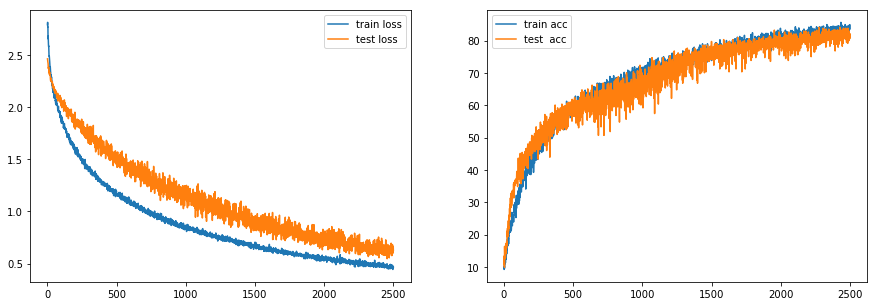

In [12]:
x = np.linspace(0,epoch,epoch+1)

tr_loss = stats[:,train,loss]
ts_loss = stats[:,test, loss]

tr_acc = stats[:, train, acc]
ts_acc = stats[:, test,  acc]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x,tr_loss,label='train loss')
plt.plot(x,ts_loss,label='test loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,tr_acc,label='train acc')
plt.plot(x,ts_acc,label='test  acc')
plt.legend()

plt.show()

In [13]:
test_file = np.load('dropout_test.npz')['res']
test_data=test_file

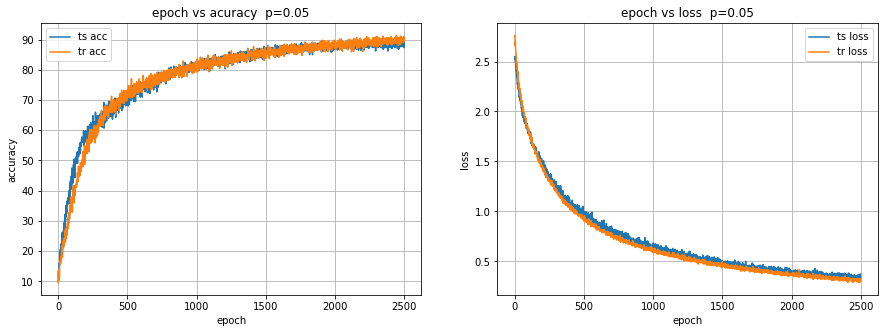

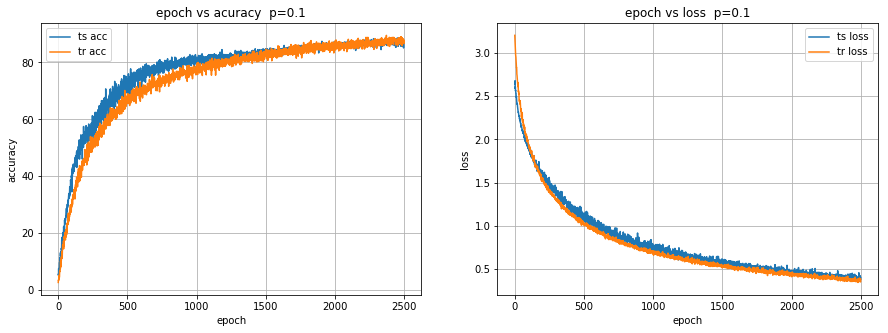

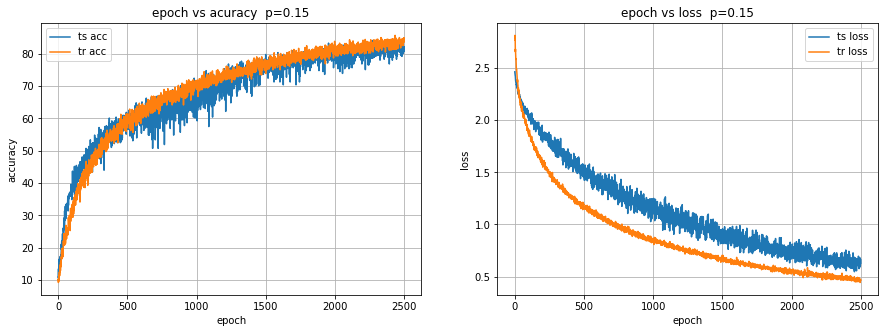

In [14]:
train = 0
test  = 1
acc   = 0
loss  = 1

x = np.linspace(0,epoch,epoch+1)
for i in range(len(drop_prob_list)):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ts_a = test_file[i,:,test,acc]
    ts_l = test_file[i,:,test,loss]
    tr_a = test_file[i,:,train,acc]
    tr_l = test_file[i,:,train,loss]
    
    plt.plot(x,ts_a,label='ts acc')
    plt.plot(x,tr_a,label='tr acc')
    plt.title('epoch vs acuracy  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(x,ts_l,label='ts loss')
    plt.plot(x,tr_l,label='tr loss')
    plt.title('epoch vs loss  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    